<a href="https://colab.research.google.com/github/Sowgandh6/VAE_Bio-medical_data_generation/blob/main/VAE_GAN_SYNTH_DATA_GENERATION_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone 'https://github.com/Sowgandh6/VAE_Bio-medical_data_generation.git'

In [3]:
cd /content/VAE_Bio-medical_data_generation

/content/VAE_Bio-medical_data_generation


In [ ]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats
from sklearn.preprocessing import MaxAbsScaler 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# loading the data
def load_data(data_file_path):
    real_data = pd.read_csv(data_file_path, delim_whitespace=True)
    return real_data.T


# transforming the data to log2
def transform_data_to_log2(data):
    log2_data = np.log2(data + 1e-8)
    # print(log2_data)
    return log2_data


def load_column_names(data):
    columns = data.columns
    return columns

def scale_maxabsscaler(data):
  mas = MaxAbsScaler()
  rescale_data = mas.fit_transform(data)
  return rescale_data, mas


# loading metadata which consists of group and batch numbers
def load_meta_data(meta_data_file_path):
    meta_data = pd.read_csv(meta_data_file_path, delim_whitespace=True)
    return meta_data

###################################################################################################
# PCA plot for real_data
def plot_pca_real_data(df_base, metadata, path):
    # print(metadata_df['batch'])
    # Perform PCA on the log2-transformed data
    pca = PCA(n_components=2)
    pca.fit(df_base)
    pca_scores = pca.transform(df_base)
    # print(pca_scores)
    # Create a DataFrame with the PCA scores and labels
    pca_df = pd.DataFrame(pca_scores,index=metadata.index, columns=['PC1', 'PC2'])
    # print(pca_df)
    pca_df['batch'] = metadata['batch'].values
    pca_df['group'] = metadata['group'].values
    # print(pca_df)
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='batch', style='group')
    plt.savefig(path + '/PCA_real_data.png')
    plt.show()
    return pca_df


# PCA plot for synthetic_data
def plot_pca_synthetic(df_synthetic, path):
    # print(metadata_df['batch'])
    # Perform PCA on the log2-transformed data
    pca = PCA(n_components=2)
    pca.fit(df_synthetic)
    pca_scores = pca.transform(df_synthetic)
    # print(pca_scores)
    # Create a DataFrame with the PCA scores and labels
    pca_df = pd.DataFrame(pca_scores, columns=['PC1', 'PC2'])
    # print(pca_df)
    sns.scatterplot(data=pca_df, x='PC1', y='PC2')
    plt.savefig(path + '/PCA_synthetic_data.png')
    plt.show()
    return pca_df

################################################################################################################################
################################  VAE ###########################################################################
# Load real_data and divide into train and valid, transform and standardise the data
def load_and_standardize_data(df_base):
    # randomly split
    X_train, X_test = train_test_split(df_base, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler


class DataBuilder(Dataset):
    def __init__(self, data, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(data)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len = self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len = self.x.shape[0]
        del self.X_train
        del self.X_test

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.len


def build_and_load_data(df_base, is_train, batch_size):
    data_set = DataBuilder(df_base, is_train)
    dataset_loader = DataLoader(dataset=data_set, batch_size=batch_size)
    return dataset_loader

def convert_data_to_torch(dataset_loader):
    dataset_torch = dataset_loader
    dataset_torch.dataset.x = dataset_torch.dataset.x.to(torch.float32)
    return dataset_torch


class VAE(nn.Module):
    def __init__(self, D_in, H=50, H2=12, latent_dim=50, p=0.3):

        # Encoder
        super(VAE, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.dropout1 = nn.Dropout(p=p)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.dropout2 = nn.Dropout(p=p)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        self.dropout3 = nn.Dropout(p=p)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin1 = self.dropout1(lin1)
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin2 = self.dropout2(lin2)
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        lin3 = self.dropout3(lin3)

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD


def train(epoch, trainloader, model,optimizer, loss_mse, train_losses):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(trainloader.dataset))
    if epoch % 10 == 0:
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
    return train_losses

def test(epoch, testloader, model,optimizer, loss_mse, test_losses):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        test_losses.append(test_loss / len(testloader.dataset))
        if epoch % 10 == 0:
            print('====> Epoch: {} Average test loss: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset)))
    return test_losses


def generate_synthetic_data(testloader_dataset_torch, trainloader_dataset_torch, columns, optimizer, model):
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader_dataset_torch):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

    scaler = trainloader_dataset_torch.dataset.standardizer
    recon_row = scaler.inverse_transform(recon_batch[0].cpu().numpy().reshape(1, -1))
    real_row = scaler.inverse_transform(testloader_dataset_torch.dataset.x[0].cpu().numpy().reshape(1, -1))
    
    df = pd.DataFrame(np.stack((np.squeeze(recon_row), np.squeeze(real_row))), columns=columns)

    sigma = torch.exp(logvar / 2)
    mu[1], sigma[1]
    mu.mean(axis=0), sigma.mean(axis=0)
    no_samples = 400
    q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
    z = q.rsample(sample_shape=torch.Size([no_samples]))
    z.shape
    z[:5]
    with torch.no_grad():
        pred = model.decode(z).cpu().numpy()
    pred[1]
    synthetic_data = scaler.inverse_transform(pred)
    

    df_synthetic = pd.DataFrame(synthetic_data, columns=columns)
    return df_synthetic

#######################################################################################################################################################
########################################### GAN #######################################################################################################
def build_generator(n_columns, latent_dim):
    model = Sequential()  
    model.add(layers.Dense(500, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2000))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5000))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(8000))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(n_columns, activation='tanh'))
    return model

def build_discriminator(inputs_n):
    model = Sequential()
    model.add(layers.Dense(6000, input_dim=inputs_n))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(2000))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='tanh'))
    model.add(layers.LeakyReLU(alpha=0.2))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    discriminator.trainable = False
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0002))
    return model

def train_gan(generator, discriminator, gan, data, latent_dim, n_epochs, batch_size):
    d_loss_history = []
    g_loss_history = []
    for i in range(n_epochs):
        # prepare real samples
        X_real = data[np.random.randint(0, data.shape[0], int(batch_size/2)), :]
        y_real = np.ones((X_real.shape[0], 1))
        # prepare fake samples
        X_fake = generator.predict(np.random.normal(0, 1, (int(batch_size/2), latent_dim)))
        y_fake = np.zeros((X_fake.shape[0], 1))
        # train discriminator
        d_loss_real = discriminator.train_on_batch(X_real, y_real)
        d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss_history.append(d_loss)
        # train generator
        X_gan = np.random.normal(0, 1, (batch_size, latent_dim))
        y_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(X_gan, y_gan)
        g_loss_history.append(g_loss)
        
        print(f"Epoch {i+1}/{n_epochs} - Discriminator Loss: {d_loss} - Generator Loss: {g_loss}")
        
    plt.plot(d_loss_history)
    plt.plot(g_loss_history)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Discriminator', 'Generator'], loc='upper right')
    plt.show()

def generate_gan_synthetic_data(generator, cols, mas):
  noise = np.random.normal(0, 1, (400, 300))
  df_synthetic = generator.predict(noise)
  df_synthetic = mas.inverse_transform(df_synthetic)
  df_synthetic = pd.DataFrame(data = df_synthetic, columns = cols)
  return df_synthetic



########################################################################################################################################################
def compute_intersection_between_top_n_real_synthetic_variances(real_pca_scores, synthetic_pca_scores, df_base, df_synthetic, row_counts=[500, 1000, 2000, 4000], path_to_save_fig=None):   
    # Get pc1 values which are less than 0 for real
    pc1_less_than_0_real = real_pca_scores.loc[(real_pca_scores['PC1'] < 0) & (real_pca_scores['PC2'] < 0)]
    # Extract indices from pc1_less_than_0_real
    indices = pc1_less_than_0_real.index   
    # Select rows from df_base with matching indices and compute variance
    variances = df_base.loc[indices].var(axis=0) 
    # Create new dataframe with computed variances
    variance_df = pd.DataFrame(variances, columns=['variance'])  
    # sort the df with respect to variance values from high to low
    variance_df = variance_df.sort_values(by='variance', ascending=False) 
    
      
    # get the values of pc1 less than 0
    pc1_less_than_0_synthetic = synthetic_pca_scores.loc[(synthetic_pca_scores['PC1'] < 0) &  (synthetic_pca_scores['PC2'] < 0)] 
    # extract those indices from pc1_less_than_0_synthetic and select the rows from df_synthetic
    var_synthetic_less_than_0 = df_synthetic.loc[pc1_less_than_0_synthetic.index]  
    #compute the variance
    var_synthetic_less_than_0 = var_synthetic_less_than_0.var(axis=0)  
    # sort the df with respect to variance values from high to low
    var_synthetic_less_than_0 = var_synthetic_less_than_0.sort_values(ascending=False)


    # get the values of pc1 more than 0
    pc1_more_than_0_synthetic = synthetic_pca_scores.loc[(synthetic_pca_scores['PC1'] > 0) & (synthetic_pca_scores['PC2'] < 0)]  
    # extract those indices from pc1_more_than_0_synthetic and select the rows from df_synthetic
    var_synthetic_more_than_0 = df_synthetic.loc[pc1_more_than_0_synthetic.index]  
    #compute the variance
    var_synthetic_more_than_0 = var_synthetic_more_than_0.var(axis=0)  
    # sort the df with respect to variance values from high to low
    var_synthetic_more_than_0 = var_synthetic_more_than_0.sort_values(ascending=False)  
    # check the intersection between the variance of top row_counts with var_synthetic_less_than_0
    results = []
    to_plot_bar_chart_1 = []
    to_plot_bar_chart_2 = []
    output_filename = "Intersection of top n most variable features between real and synthetic.csv"

    # If a path to save the file is provided, add it to the filename
    if path_to_save_fig:
        output_filename = f"{path_to_save_fig}/{output_filename}"

    # Write results to the CSV file
    with open(output_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['n', 'Intersection of top n most variable features between real and synthetic', 'intersection'])
        for n in row_counts:
            a = variance_df.head(n)
            b = var_synthetic_less_than_0.head(n)
            intersection = len(a.index.intersection(b.index))
            to_plot_bar_chart_1.append(intersection)
            writer.writerow([n, 'less than 0', intersection])
            results.append(print((f"Intersection of top {n} features (less than 0): ", intersection)))

        for n in row_counts:
            a = variance_df.head(n)
            b = var_synthetic_more_than_0.head(n)
            intersection = len(a.index.intersection(b.index))
            to_plot_bar_chart_2.append(intersection)
            writer.writerow([n, 'more than 0', intersection])
            results.append(print((f"Intersection of top {n} features (more than 0): ", intersection)))

        normalized_data_1 = np.array(to_plot_bar_chart_1) / np.array(row_counts)
        normalized_data_2 = np.array(to_plot_bar_chart_2) / np.array(row_counts)
        # Define the data to plot
        top_n_features_x_axis = [str(value) for value in row_counts]
        # Set the width of the bars
        width = 0.35
        # Define the colors for each set of bars
        color1 = 'tab:blue'
        color2 = 'tab:orange'
        # Create the bar chart
        fig, ax = plt.subplots()
        ax.bar([i - width/2 for i in range(len(top_n_features_x_axis))], normalized_data_1, width, label='Real PC1 < 0 vs synthetic PC1 < 0', color=color1)
        ax.bar([i + width/2 for i in range(len(top_n_features_x_axis))], normalized_data_2, width, label='Real PC1 < 0 vs synthetic PC2 > 0', color=color2)
        # Add labels and titles
        ax.set_xlabel('Top_n_features')
        ax.set_ylabel('Intersection')
        ax.set_title('Intersection of top n most variable features between real and synthetic')
        ax.set_xticks(range(len(top_n_features_x_axis)))
        ax.set_xticklabels(top_n_features_x_axis)
        ax.legend()
        plt.savefig(path_to_save_fig + '/Intersection of top n most variable features between real and synthetic.png')
        plt.show()  
    return to_plot_bar_chart_1, to_plot_bar_chart_2, variance_df, var_synthetic_less_than_0, var_synthetic_more_than_0

###############################################################################################################################
def get_diff_exp_indices_features(indices_path,df_base_stored_to_use_if_needed):
  indices = pd.read_csv(indices_path, delim_whitespace=True)
  indices_list = indices['x'].tolist()
  stored_col_indices = indices_list
  stored_col_names = [df_base_stored_to_use_if_needed.columns[i-1] for i in stored_col_indices]
  return stored_col_names
##################################################################################################################################
def top_varied_indices_comparision_in_real_and_synthetic_data(stored_col_names, real_pca_scores, synthetic_pca_scores, df_base, df_synthetic, n_values=[1000, 2000, 3000, 4000], path_to_save_fig=None):
  pc1_less_than_0_real = real_pca_scores.loc[real_pca_scores['PC1'] < 0, ['PC1']]
  indices = pc1_less_than_0_real.index
  variances = df_base.loc[indices].var(axis=0)
  variance_df = pd.DataFrame(variances, columns=['variance'])
  variance_df = variance_df.sort_values(by='variance', ascending=False)

  pc1_less_than_0_synthetic = synthetic_pca_scores.loc[synthetic_pca_scores['PC1'] < 0, ['PC1']]
  var_synthetic_less_than_0 = df_synthetic.loc[pc1_less_than_0_synthetic.index]
  var_synthetic_less_than_0 = var_synthetic_less_than_0.var(axis=0)
  var_synthetic_less_than_0 = var_synthetic_less_than_0.sort_values(ascending=False)

  intersection_real_list = []
  intersection_synthetic_list = []

  for n in n_values:
    c = variance_df.head(n)
    d = stored_col_names
    intersection_real = len(c.index.intersection(d))
    intersection_real_list.append(intersection_real)

    c = var_synthetic_less_than_0.head(n)
    intersection_synthetic = len(c.index.intersection(d))
    intersection_synthetic_list.append(intersection_synthetic)

  print(intersection_real_list)
  print(intersection_synthetic_list)
  intersection_real_list = np.array(intersection_real_list) / len(stored_col_names)
  intersection_synthetic_list = np.array(intersection_synthetic_list) / len(stored_col_names)

  top_n_features_x_axis = [str(value) for value in n_values]

  width = 0.35
  color1 = 'tab:blue'
  color2 = 'tab:orange'

  fig, ax = plt.subplots()
  ax.bar([i - width/2 for i in range(len(top_n_features_x_axis))], intersection_real_list, width, label='Real PC1 vs Top varied features', color=color1)
  ax.bar([i + width/2 for i in range(len(top_n_features_x_axis))], intersection_synthetic_list, width, label='synthetic PC1 vs Top varied features', color=color2)
  

  ax.set_xlabel('Top_n_features')
  ax.set_ylabel('Intersection')
  ax.set_title('R vs S proportion of ground truth signal among the most variable genes')
  ax.set_xticks(range(len(top_n_features_x_axis)))
  ax.set_xticklabels(top_n_features_x_axis)
  ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=8)
  if path_to_save_fig is not None:
    plt.savefig(path_to_save_fig + '/Real vs synthetic proportion of ground truth signal among the most variable genes.png', dpi=300, bbox_inches='tight')
  plt.show() 

  output_filename = "Real vs synthetic proportion of ground truth signal among the most variable genes.csv"
  if path_to_save_fig:
    output_filename = f"{path_to_save_fig}/{output_filename}" 
  with open(output_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['n_values', 'intersection_real', 'intersection_synthetic'])
        writer.writerow([n_values, intersection_real_list, intersection_synthetic_list])




def scatter_plot_of_variances_in_real_and_synthetic(variance_df, var_synthetic_less_than_0, path):
  # combined the var of real and synthetic data into a dataframe
  df_variance_values_real_synthetic = pd.concat([ variance_df,var_synthetic_less_than_0], axis=1)
  #scatter plot for real_synthetic data variances
  plt.scatter(df_variance_values_real_synthetic.iloc[:, 0], df_variance_values_real_synthetic.iloc[:, 1])
  plt.xlabel("Real")
  plt.ylabel("synthetic")
  plt.title("Scatter plot of Real vs. synthetic")
  plt.savefig(path + '/scatterplot_variances_in_real_synthetic.png')
  plt.show()

  plt.scatter(df_variance_values_real_synthetic.iloc[:, 0], df_variance_values_real_synthetic.iloc[:, 1])
  plt.xlabel("Real")
  plt.ylabel("synthetic")
  plt.title("Scatter plot of Real vs. synthetic")
  plt.xlim(0, 70)
  plt.ylim(0, 10)
  plt.savefig(path + '/scatterplot_variances_in_real_synthetic_zoom.png')
  plt.show()
###############################################################################################################################
def pick_common_columns(df1, df2, num_cols):
    """Picks a specified number of columns with the same names from two dataframes."""
    # Calculate the step size for selecting columns
    step_size = len(df1.columns) // num_cols
    # Generate a list of evenly spaced indices
    col_indices = np.arange(0, len(df1.columns), step_size)[:num_cols]
    # Select the columns with those indices from df1
    selected_cols = df1.columns[col_indices]
    # Select the columns from the two dataframes and return them
    df1_selected = df1[selected_cols]
    df2_selected = df2[selected_cols]
    return df1_selected, df2_selected

def plot_density(df1, df2, path):
    """Plots the density plots of two dataframes, with each plot containing all columns."""
    # Set the figure size
    figsize = (14, 5)
    # Create the plot for dataframe 1
    fig, axes = plt.subplots(ncols=2, figsize=figsize, sharey=True)
    sns.kdeplot(data=df1, ax=axes[0], legend=False, fill=True)
    axes[0].set_title('Real_data')
    # Create the plot for dataframe 2
    sns.kdeplot(data=df2, ax=axes[1], legend=False, fill=True)
    
    axes[1].set_title('synthetic_data')
    # Set the labels
    plt.setp(axes, ylabel='Density')
    plt.savefig(path + '/density_plot.png')
    # Show the plot
    plt.show()
###################################################################################################################################################
import os
import csv

def get_pos_neg_indices_from_pca_values_and_get_those_features_mean_diff_and_intersect_with_stored_col_names(synthetic_pca_scores, stored_col_names, df_synthetic, threshold_value, path_to_save_fig):
    # getting the values of pc1 less than 0
    pc1_less_than_0_synthetic = synthetic_pca_scores.loc[synthetic_pca_scores['PC1'] < 0]
    #sorting the values with respect to pc2
    pc1_less_than_0_synthetic.sort_values(by=['PC2'])
    # create empty lists to store positive and negative indices of pc1_less_than_0_synthetic
    positive_indices = []
    negative_indices = []
    # loop through the PC2 column of the dataframe
    for index, value in pc1_less_than_0_synthetic['PC2'].items():
        if value > 0:
            positive_indices.append(index)
        elif value < 0:
            negative_indices.append(index)

    #get data from df_synthetic
    synthetic_positive_indices = df_synthetic.iloc[positive_indices]
    synthetic_negative_indices = df_synthetic.iloc[negative_indices]

    #calculate mean for positive and negative indices features from df_synthetic
    positive_mean = synthetic_positive_indices.mean()
    negative_mean = synthetic_negative_indices.mean()

    # taking the difference of means in both the groups and taking the absolute value and
    # diff_mean are sorted
    difference = abs(positive_mean - negative_mean)
    difference_sorted = difference.sort_values(ascending=False)
    intersection_count = len(difference_sorted.head(threshold_value).index.intersection(stored_col_names))
    
    # Write output to CSV file
    filename = "no_of_inter_in_synthetic_with_top_indices.csv"
    file_path = os.path.join(path_to_save_fig, filename)
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Intersection of most varied features from real_data with synthetic_data', intersection_count])
    print(intersection_count)
    return intersection_count

########################################################################################################################
def calculate_precision_recall(detected, stored_col_names, threshold):
  recall = detected/len(stored_col_names)
  precision = detected/threshold
  print("Recall is:", recall)
  print("Precision is:", precision)
  return recall, precision
  ################################################################################################################

def box_plot_for_precision_recall(precision_values, recall_values):
  # Calculate mean and standard deviation for precision and recall
  precision_mean = sum(precision_values) / len(precision_values)
  precision_std = np.std(precision_values)
  recall_mean = sum(recall_values) / len(recall_values)
  recall_std = np.std(recall_values)

  # Create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

  # Plot precision boxplot on left subplot
  ax1.boxplot(precision_values)
  ax1.set_title('Precision')
  ax1.set_ylabel('Value')
  ax1.set_xticklabels([''])

  # Add mean and standard deviation to precision boxplot
  ax1.axhline(precision_mean, color='red', linestyle='--', linewidth=2)
  ax1.axhline(precision_mean - precision_std, color='orange', linestyle='--', linewidth=2)
  ax1.axhline(precision_mean + precision_std, color='orange', linestyle='--', linewidth=2)

  # Plot recall boxplot on right subplot
  ax2.boxplot(recall_values)
  ax2.set_title('Recall')
  ax2.set_ylabel('Value')
  ax2.set_xticklabels([''])

  # Add mean and standard deviation to recall boxplot
  ax2.axhline(recall_mean, color='red', linestyle='--', linewidth=2)
  ax2.axhline(recall_mean - recall_std, color='orange', linestyle='--', linewidth=2)
  ax2.axhline(recall_mean + recall_std, color='orange', linestyle='--', linewidth=2)

  plt.savefig('/content/VAE_Bio-medical_data_generation/DATASETS/Box_plot.png')
  # Show the plot
  plt.show()
  return 'Box_plot_saved'
  

In [ ]:
def train_variational_autoencoder():  
  precision_values = []
  recall_values = []
  for i in range(1, 11):
      # update file paths for each iteration
      data_file_path = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}/exprs_mat.txt'
      meta_data_file_path = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}/metadata.txt'
      diff_exp_indices_file_path = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}/diff_exp_indices.txt'
      path_to_save_fig = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}'
      
      #load data file and get df_base and cols
      df_base = load_data(data_file_path)
      df_base = transform_data_to_log2(df_base)
      df_base_stored_to_use_if_needed = df_base
      cols = load_column_names(df_base)

      #load meta_data
      meta_data = load_meta_data(meta_data_file_path)

      #load highly_diff_exp_indices
      stored_col_names = get_diff_exp_indices_features(diff_exp_indices_file_path, df_base_stored_to_use_if_needed)

      #perform PCA on real data and get real_pca_scores
      real_pca_scores = plot_pca_real_data(df_base, meta_data, path_to_save_fig)

      # Load the dataset and convert to torch
      trainloader_dataset = build_and_load_data(df_base, is_train=True, batch_size=256)
      testloader_dataset = build_and_load_data(df_base, is_train=False, batch_size=256)
      trainloader_dataset_torch = convert_data_to_torch(trainloader_dataset)
      testloader_dataset_torch = convert_data_to_torch(testloader_dataset)

      #Give D_in dimension and load the VAE model and Loss
      D_in = trainloader_dataset_torch.dataset.x.shape[1]
      model = VAE(D_in, H=6000, H2=2000,  latent_dim=200).to(device)
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      loss_mse = customLoss()

      file_path = os.path.join(path_to_save_fig, 'losses.csv')
      epochs = 250
      train_losses = []
      test_losses = []

      # Write the column names to the CSV file
      with open(file_path, 'w', newline='') as csvfile:
          writer = csv.writer(csvfile)
          writer.writerow(['epoch', 'train_loss', 'test_loss'])

      # Iterate over the epochs and write the loss values to the CSV file
      for epoch in range(1, epochs + 1):
          train_losses = train(epoch, trainloader_dataset_torch, model,optimizer, loss_mse, train_losses)
          test_losses = test(epoch, testloader_dataset_torch, model,optimizer, loss_mse, test_losses)

          if epoch % 10 == 0:
              with open(file_path, 'a', newline='') as csvfile:
                  writer = csv.writer(csvfile)
                  writer.writerow([epoch, train_losses[-1], test_losses[-1]])
      
      x = range(1, len(train_losses) + 1)

      # plot train and test losses
      plt.plot(x, train_losses, label='Train Loss')
      plt.plot(x, test_losses, label='Test Loss')
      # add axis labels and title
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Train and Test Losses')
      # add legend
      plt.legend()
      plt.savefig(path_to_save_fig + '/Train_valid_loss.png')
      plt.show()


      # Generate df_synthetic from the trained VAE
      df_synthetic = generate_synthetic_data(testloader_dataset_torch, trainloader_dataset_torch, columns=cols, optimizer=optimizer, model=model)
      df_synthetic_stored_to_use_if_needed = df_synthetic
      
      #perform PCA on synthetic data and get synthetic_pca_scores
      synthetic_pca_scores = plot_pca_synthetic(df_synthetic, path_to_save_fig)

      #Intersection of top n_features with PC1 values in reAL AND synthetic DATA WHERE pc1 in real is less than 0/ and in synthetic less and more than
      
      to_plot_bar_chart_1, to_plot_bar_chart_2, variance_df, var_synthetic_less_than_0, var_synthetic_more_than_0 = compute_intersection_between_top_n_real_synthetic_variances(real_pca_scores, synthetic_pca_scores, df_base, df_synthetic, path_to_save_fig=path_to_save_fig)
      #highly varied features obtained with the help of diff_exp_indices in the top_n of real_data and synthetic data
      results = top_varied_indices_comparision_in_real_and_synthetic_data(stored_col_names, real_pca_scores, synthetic_pca_scores, df_base, df_synthetic, n_values=[1000, 2000, 3000, 4000], path_to_save_fig=path_to_save_fig)

      # Scatterplot of variances in real and synthetic data
      scatter_plot_of_variances_in_real_and_synthetic(variance_df, var_synthetic_less_than_0, path_to_save_fig)

      # Randomly pick n rows from real and synthetic data and subset them. Plot a density plot for real and synthetic data side by side.
      df_base_selected_columns, df_synthetic_selected_columns = pick_common_columns(df_base_stored_to_use_if_needed, df_synthetic_stored_to_use_if_needed, num_cols=3000)

      # Density plot for randomly selected n features both from real and synthetic data
      plot_density(df_base_selected_columns, df_synthetic_selected_columns, path_to_save_fig)

      threshold_value = 2050
      # Checking the intersection of most varied 2000 indices with top mean_diff
      detected = get_pos_neg_indices_from_pca_values_and_get_those_features_mean_diff_and_intersect_with_stored_col_names(synthetic_pca_scores, stored_col_names, df_synthetic, threshold_value, path_to_save_fig=path_to_save_fig)

      # Recall and precision
      recall, precision = calculate_precision_recall(detected, stored_col_names, threshold_value)

      # Append precision and recall values to the lists
      precision_values.append(precision)
      recall_values.append(recall)
  box_plot_for_precision_recall(precision_values, recall_values)
  return 'Successfully trained'
#####################################################################################################################################################################################################################################################################################################################################################################
def train_GAN():
  precision_values = []
  recall_values = []
  for i in range(1, 11):  
    data_file_path = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}/exprs_mat.txt'
    meta_data_file_path = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}/metadata.txt'
    diff_exp_indices_file_path = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}/diff_exp_indices.txt'
    path_to_save_fig = f'/content/VAE_Bio-medical_data_generation/DATASETS/sim_data_{i}'
    #load data file and get df_base and cols
    df_base = load_data(data_file_path)
    df_base = transform_data_to_log2(df_base)
    df_base_stored_to_use_if_needed = df_base
    cols = load_column_names(df_base)
    df_base, mas = scale_maxabsscaler(df_base)
    #load meta_data
    meta_data = load_meta_data(meta_data_file_path)
    stored_col_names = get_diff_exp_indices_features(diff_exp_indices_file_path, df_base_stored_to_use_if_needed)
    real_pca_scores = plot_pca_real_data(df_base, meta_data, path_to_save_fig)

    generator = build_generator(n_columns=df_base.shape[1], latent_dim=300)
    discriminator = build_discriminator(inputs_n=df_base.shape[1])
    #generator compile
    generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.0002)
    generator_loss = 'binary_crossentropy'
    generator.compile(optimizer=generator_optimizer, loss=generator_loss)
    #discriminator compile
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    discriminator_loss = 'binary_crossentropy'
    discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

    gan = build_gan(generator, discriminator)
    train_gan(generator, discriminator, gan, df_base, latent_dim=300, n_epochs=1000, batch_size=128)
  # Generate synthetic data from trained vae
    df_synthetic = generate_gan_synthetic_data(generator, cols, mas)
    df_synthetic_stored_to_use_if_needed = df_synthetic
  #perform PCA on synthetic data and get synthetic_pca_scores
    synthetic_pca_scores = plot_pca_synthetic(df_synthetic, path_to_save_fig)

    #Intersection of top n_features with PC1 values in reAL AND synthetic DATA WHERE pc1 in real is less than 0/ and in synthetic less and more than
      
    to_plot_bar_chart_1, to_plot_bar_chart_2, variance_df, var_synthetic_less_than_0, var_synthetic_more_than_0 = compute_intersection_between_top_n_real_synthetic_variances(real_pca_scores, synthetic_pca_scores, df_base_stored_to_use_if_needed, df_synthetic, path_to_save_fig=path_to_save_fig)
      #highly varied features obtained with the help of diff_exp_indices in the top_n of real_data and synthetic data
    results = top_varied_indices_comparision_in_real_and_synthetic_data(stored_col_names, real_pca_scores, synthetic_pca_scores, df_base_stored_to_use_if_needed, df_synthetic, n_values=[1000, 2000, 3000, 4000], path_to_save_fig=path_to_save_fig)

      # Scatterplot of variances in real and synthetic data
    scatter_plot_of_variances_in_real_and_synthetic(variance_df, var_synthetic_less_than_0, path_to_save_fig)

      # Randomly pick n rows from real and synthetic data and subset them. Plot a density plot for real and synthetic data side by side.
    df_base_selected_columns, df_synthetic_selected_columns = pick_common_columns(df_base_stored_to_use_if_needed, df_synthetic_stored_to_use_if_needed, num_cols=3000)

      # Density plot for randomly selected n features both from real and synthetic data
    plot_density(df_base_selected_columns, df_synthetic_selected_columns, path_to_save_fig)

    threshold_value = 2050
      # Checking the intersection of most varied 2000 indices with top mean_diff
    detected = get_pos_neg_indices_from_pca_values_and_get_those_features_mean_diff_and_intersect_with_stored_col_names(synthetic_pca_scores, stored_col_names, df_synthetic, threshold_value, path_to_save_fig=path_to_save_fig)

      # Recall and precision
    recall, precision = calculate_precision_recall(detected, stored_col_names, threshold_value)

      # Append precision and recall values to the lists
    precision_values.append(precision)
    recall_values.append(recall)
  box_plot_for_precision_recall(precision_values, recall_values)
  return 'Sucessfully trained'

====> Epoch: 10 Average training loss: 5711.1052
====> Epoch: 10 Average test loss: 5889.5776
====> Epoch: 20 Average training loss: 5131.8667
====> Epoch: 20 Average test loss: 5494.4458
====> Epoch: 30 Average training loss: 5038.6675
====> Epoch: 30 Average test loss: 5433.5188
====> Epoch: 40 Average training loss: 4972.4354
====> Epoch: 40 Average test loss: 5386.9974
====> Epoch: 50 Average training loss: 4913.9072
====> Epoch: 50 Average test loss: 5317.5146
====> Epoch: 60 Average training loss: 4857.1153
====> Epoch: 60 Average test loss: 5246.9745
====> Epoch: 70 Average training loss: 4808.4250
====> Epoch: 70 Average test loss: 5192.3646
====> Epoch: 80 Average training loss: 4764.1587
====> Epoch: 80 Average test loss: 5147.6323
====> Epoch: 90 Average training loss: 4718.3890
====> Epoch: 90 Average test loss: 5108.1156
====> Epoch: 100 Average training loss: 4677.8389
====> Epoch: 100 Average test loss: 5069.5714
====> Epoch: 110 Average training loss: 4644.3040
====> Ep

('Intersection of top 500 features (less than 0): ', 144)
('Intersection of top 1000 features (less than 0): ', 224)
('Intersection of top 2000 features (less than 0): ', 553)
('Intersection of top 4000 features (less than 0): ', 1843)
('Intersection of top 500 features (more than 0): ', 142)
('Intersection of top 1000 features (more than 0): ', 210)
('Intersection of top 2000 features (more than 0): ', 593)
('Intersection of top 4000 features (more than 0): ', 1990)


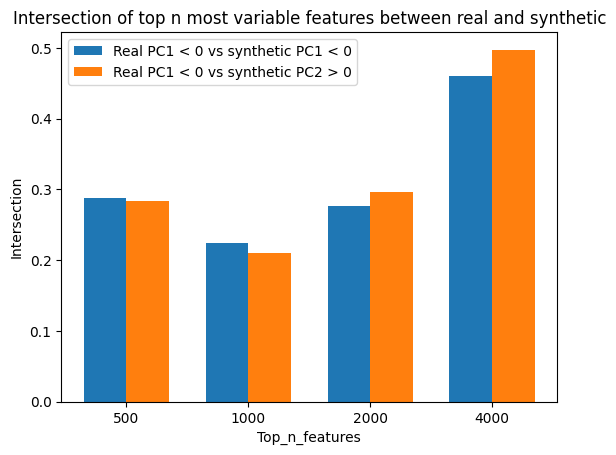

[339, 980, 1660, 1999]
[869, 1848, 2000, 2000]


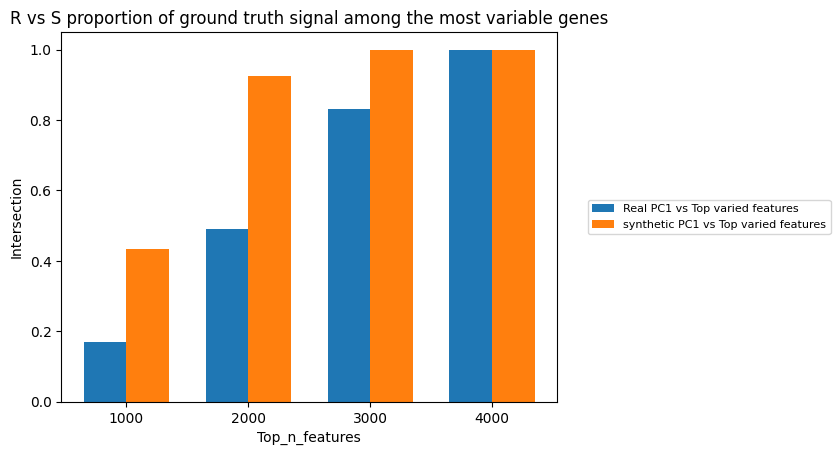

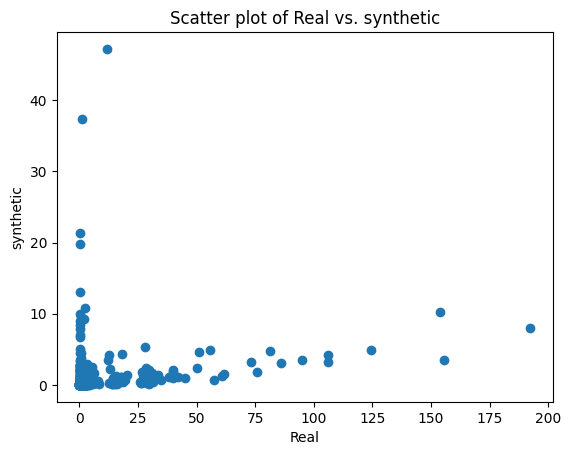

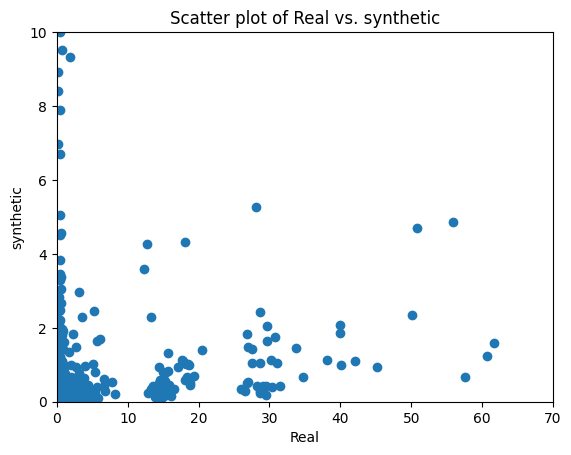

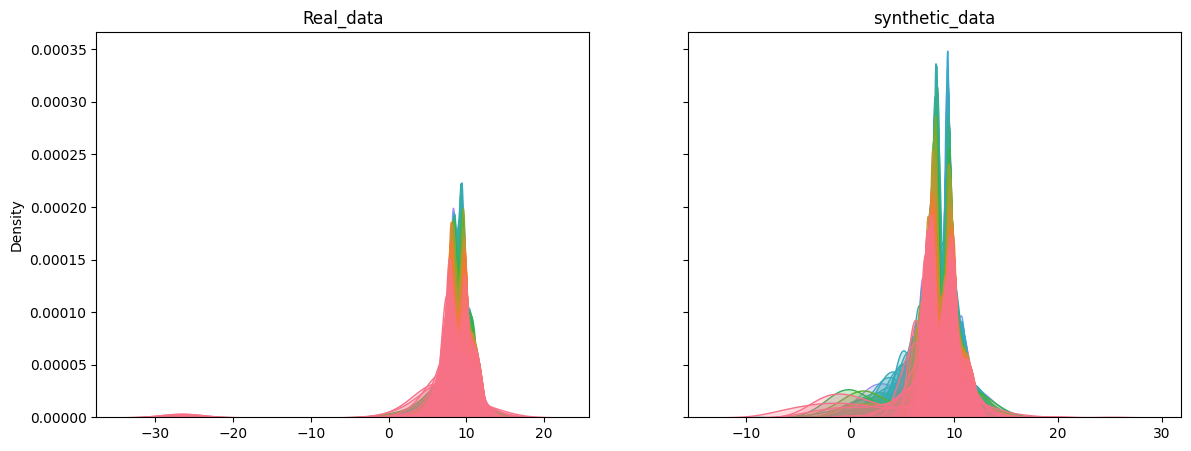

1999
Recall is: 0.9995
Precision is: 0.9751219512195122


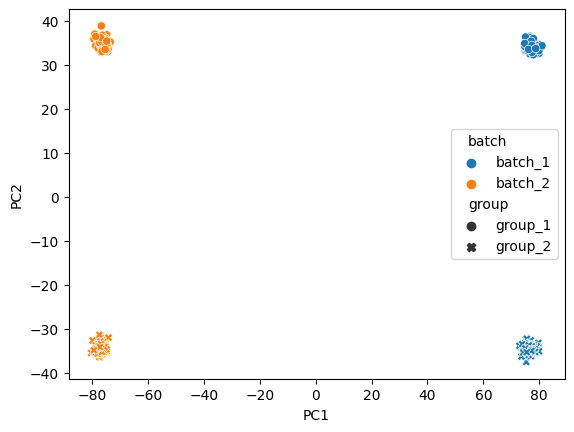

====> Epoch: 10 Average training loss: 5767.5769
====> Epoch: 10 Average test loss: 5850.8464
====> Epoch: 20 Average training loss: 5094.0524
====> Epoch: 20 Average test loss: 5387.5786
====> Epoch: 30 Average training loss: 5013.1427
====> Epoch: 30 Average test loss: 5345.2354
====> Epoch: 40 Average training loss: 4949.0282
====> Epoch: 40 Average test loss: 5279.6130
====> Epoch: 50 Average training loss: 4888.8251
====> Epoch: 50 Average test loss: 5219.8594
====> Epoch: 60 Average training loss: 4836.3414
====> Epoch: 60 Average test loss: 5164.7547
====> Epoch: 70 Average training loss: 4789.4884
====> Epoch: 70 Average test loss: 5113.1927
====> Epoch: 80 Average training loss: 4742.3743
====> Epoch: 80 Average test loss: 5079.4755
====> Epoch: 90 Average training loss: 4699.8715
====> Epoch: 90 Average test loss: 5027.2583
====> Epoch: 100 Average training loss: 4661.4548
====> Epoch: 100 Average test loss: 4995.3938
====> Epoch: 110 Average training loss: 4630.4912
====> Ep

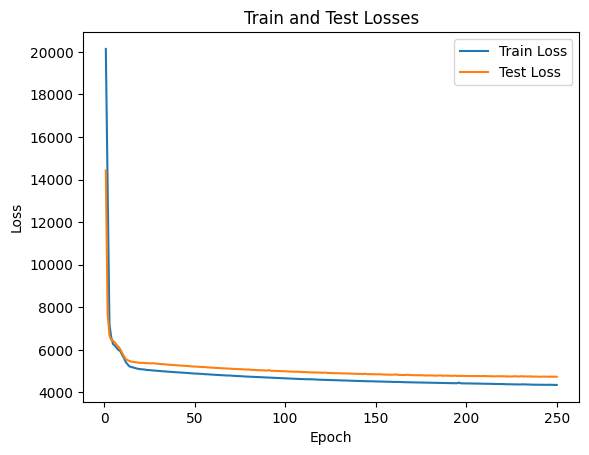

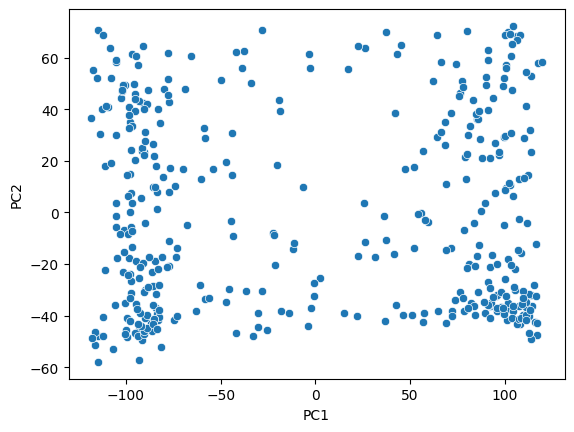

('Intersection of top 500 features (less than 0): ', 191)
('Intersection of top 1000 features (less than 0): ', 292)
('Intersection of top 2000 features (less than 0): ', 611)
('Intersection of top 4000 features (less than 0): ', 1899)
('Intersection of top 500 features (more than 0): ', 154)
('Intersection of top 1000 features (more than 0): ', 248)
('Intersection of top 2000 features (more than 0): ', 582)
('Intersection of top 4000 features (more than 0): ', 1918)


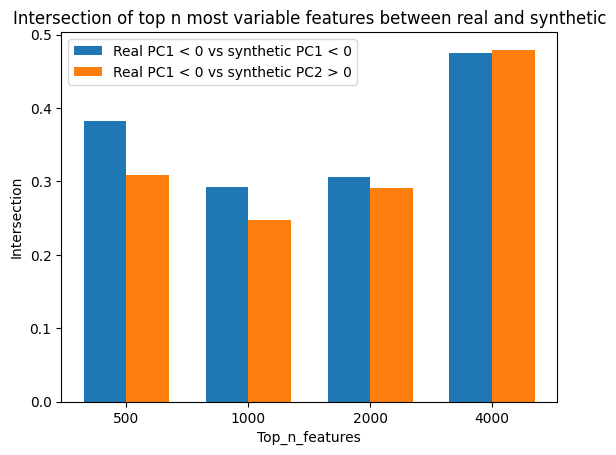

[332, 986, 1658, 2000]
[884, 1854, 2000, 2000]


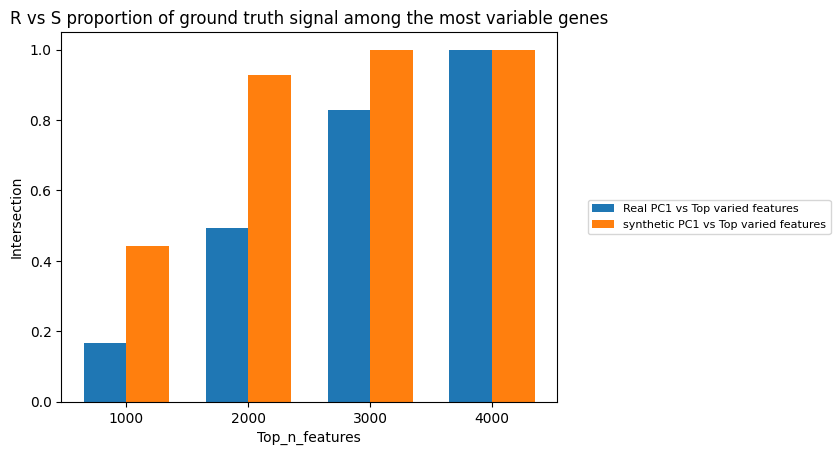

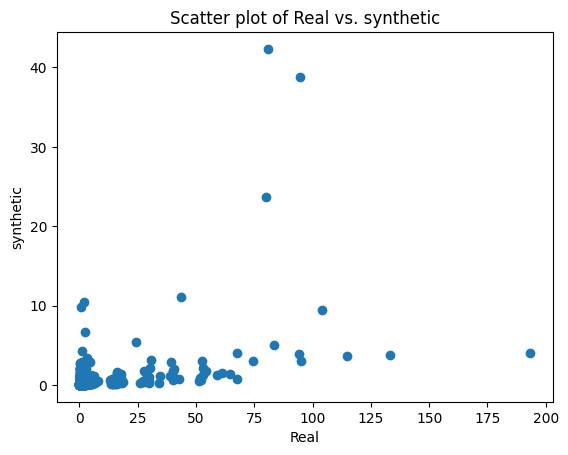

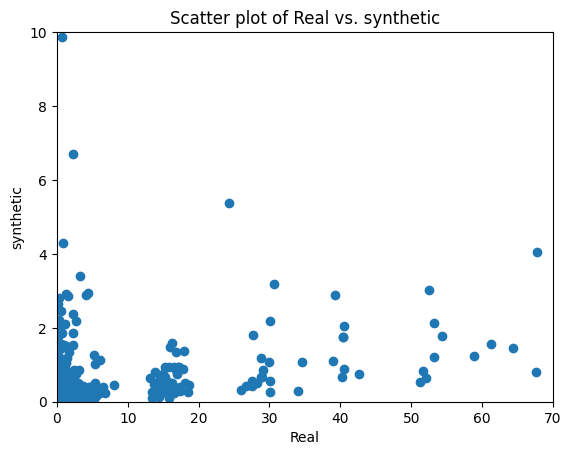

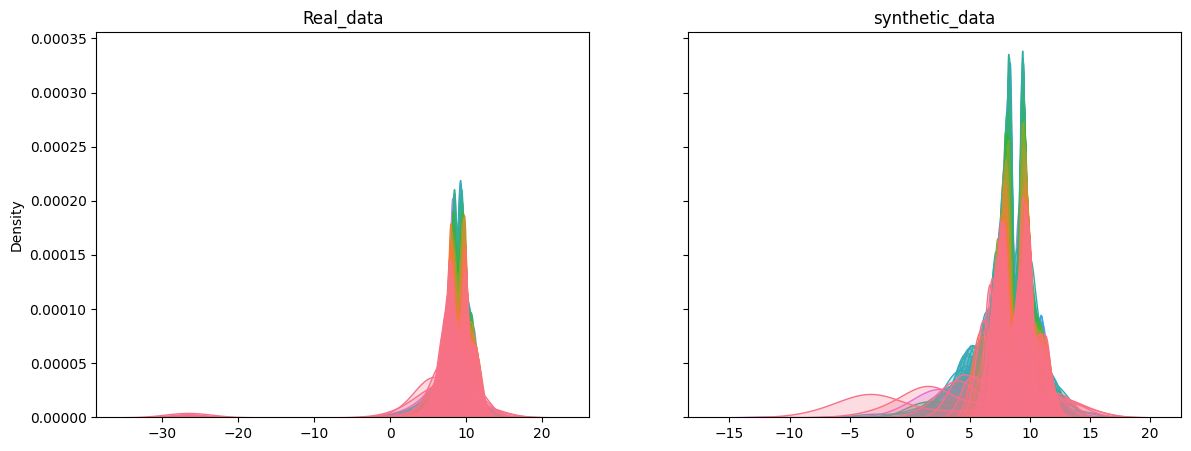

2000
Recall is: 1.0
Precision is: 0.975609756097561


====> Epoch: 10 Average training loss: 5445.8821
====> Epoch: 10 Average test loss: 5617.0703
====> Epoch: 20 Average training loss: 5065.2516
====> Epoch: 20 Average test loss: 5384.7276
====> Epoch: 30 Average training loss: 4985.4077
====> Epoch: 30 Average test loss: 5324.0656
====> Epoch: 40 Average training loss: 4920.1686
====> Epoch: 40 Average test loss: 5258.5786
====> Epoch: 50 Average training loss: 4863.7411
====> Epoch: 50 Average test loss: 5194.9682
====> Epoch: 60 Average training loss: 4808.6871
====> Epoch: 60 Average test loss: 5144.2260
====> Epoch: 70 Average training loss: 4760.6879
====> Epoch: 70 Average test loss: 5097.0120
====> Epoch: 80 Average training loss: 4717.4282
====> Epoch: 80 Average test loss: 5051.2172
====> Epoch: 90 Average training loss: 4674.7044
====> Epoch: 90 Average test loss: 5006.3760
====> Epoch: 100 Average training loss: 4635.4921
====> Epoch: 100 Average test loss: 4975.1646
====> Epoch: 110 Average training loss: 4604.6185
====> Ep

('Intersection of top 500 features (less than 0): ', 189)
('Intersection of top 1000 features (less than 0): ', 323)
('Intersection of top 2000 features (less than 0): ', 670)
('Intersection of top 4000 features (less than 0): ', 1993)
('Intersection of top 500 features (more than 0): ', 144)
('Intersection of top 1000 features (more than 0): ', 236)
('Intersection of top 2000 features (more than 0): ', 577)
('Intersection of top 4000 features (more than 0): ', 1863)


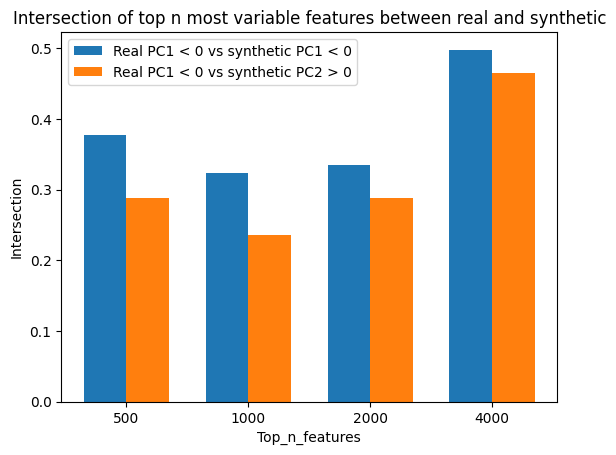

[354, 1000, 1675, 2000]
[862, 1834, 2000, 2000]


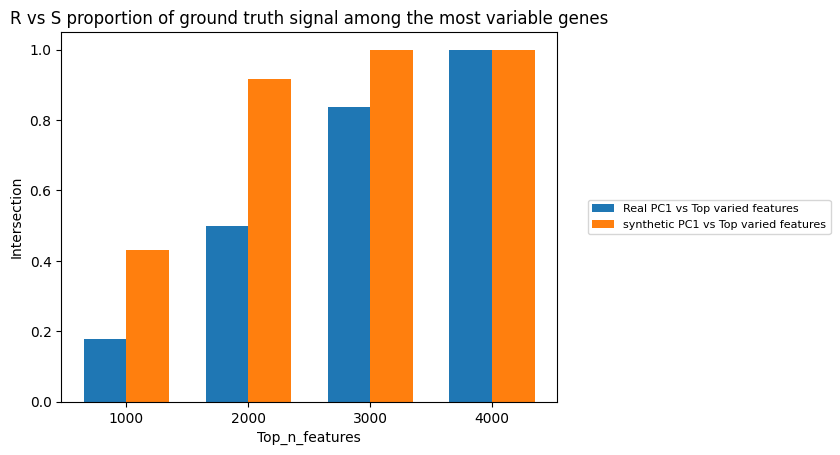

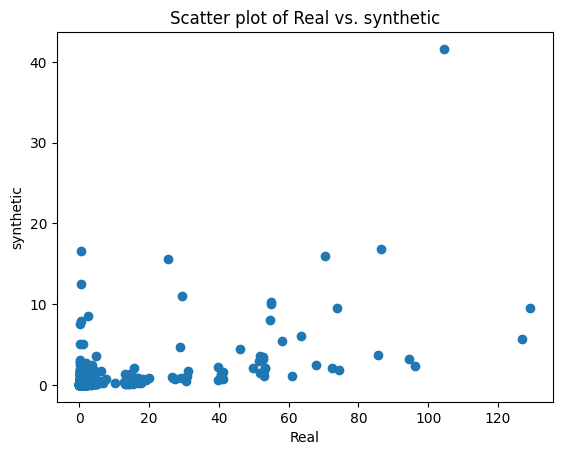

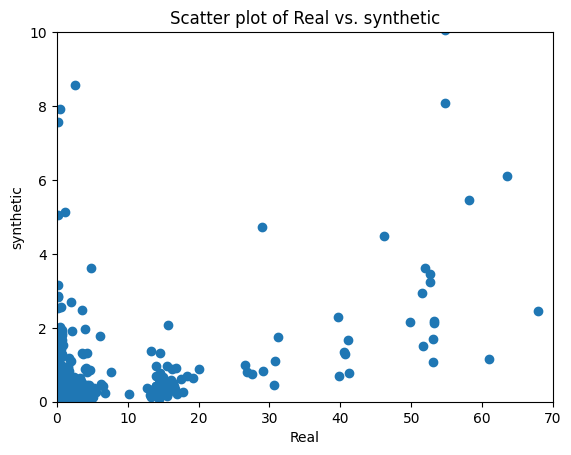

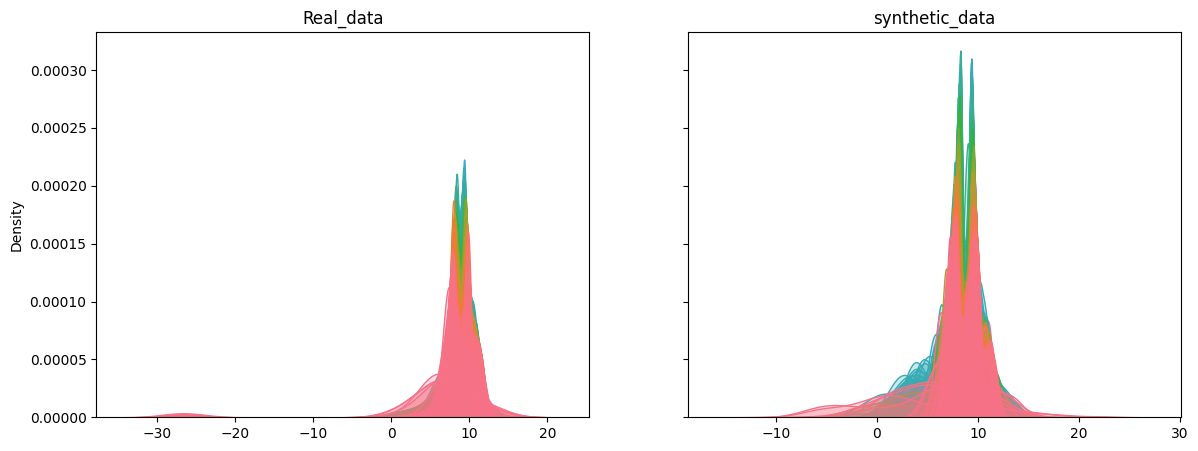

2000
Recall is: 1.0
Precision is: 0.975609756097561


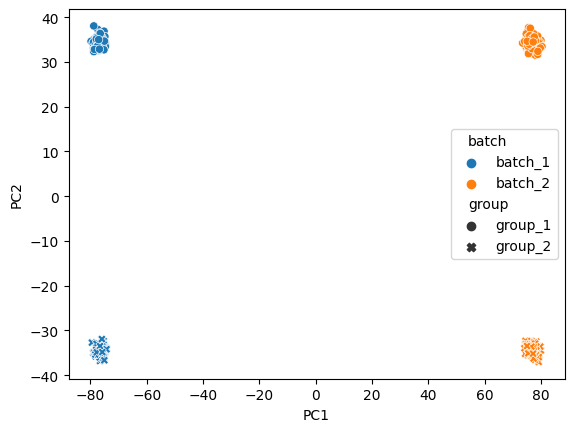

====> Epoch: 10 Average training loss: 5635.9665
====> Epoch: 10 Average test loss: 5767.3385
====> Epoch: 20 Average training loss: 5148.2149
====> Epoch: 20 Average test loss: 5454.0698
====> Epoch: 30 Average training loss: 5072.3606
====> Epoch: 30 Average test loss: 5399.9599
====> Epoch: 40 Average training loss: 5004.3208
====> Epoch: 40 Average test loss: 5328.6516
====> Epoch: 50 Average training loss: 4955.1455
====> Epoch: 50 Average test loss: 5273.5464
====> Epoch: 60 Average training loss: 4891.4197
====> Epoch: 60 Average test loss: 5225.9812
====> Epoch: 70 Average training loss: 4843.4816
====> Epoch: 70 Average test loss: 5171.3943
====> Epoch: 80 Average training loss: 4797.2523
====> Epoch: 80 Average test loss: 5132.6333
====> Epoch: 90 Average training loss: 4757.6518
====> Epoch: 90 Average test loss: 5089.5859
====> Epoch: 100 Average training loss: 4714.2410
====> Epoch: 100 Average test loss: 5042.1120
====> Epoch: 110 Average training loss: 4681.9925
====> Ep

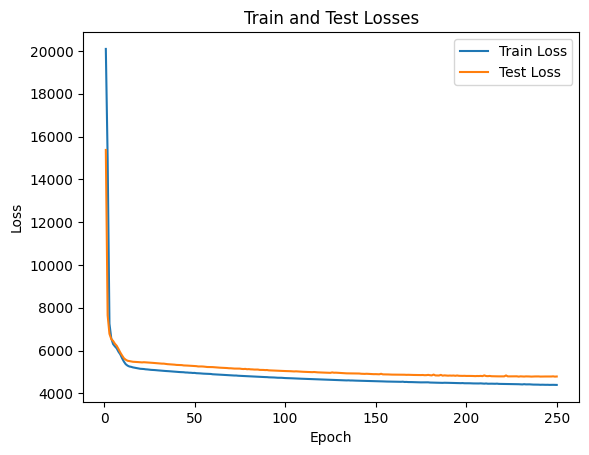

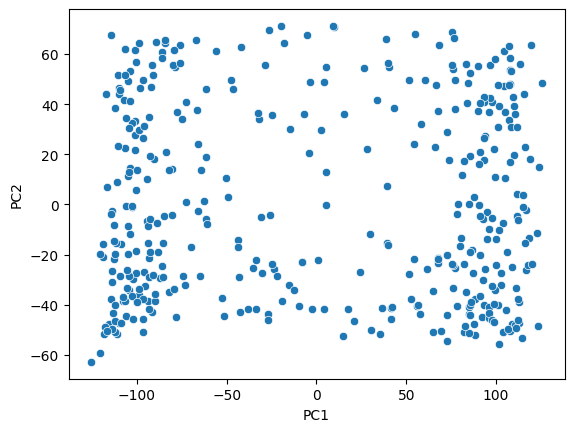

('Intersection of top 500 features (less than 0): ', 201)
('Intersection of top 1000 features (less than 0): ', 326)
('Intersection of top 2000 features (less than 0): ', 658)
('Intersection of top 4000 features (less than 0): ', 1879)
('Intersection of top 500 features (more than 0): ', 149)
('Intersection of top 1000 features (more than 0): ', 242)
('Intersection of top 2000 features (more than 0): ', 534)
('Intersection of top 4000 features (more than 0): ', 1788)


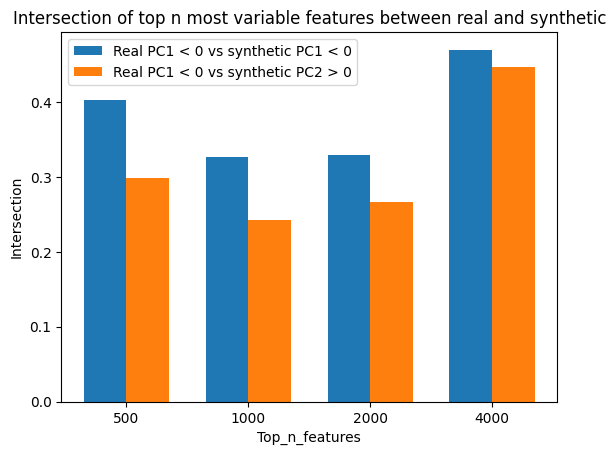

[319, 970, 1615, 1996]
[832, 1810, 2000, 2000]


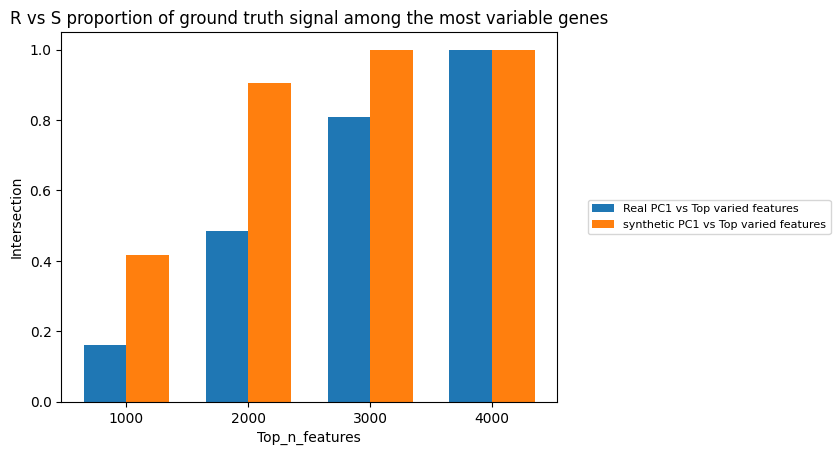

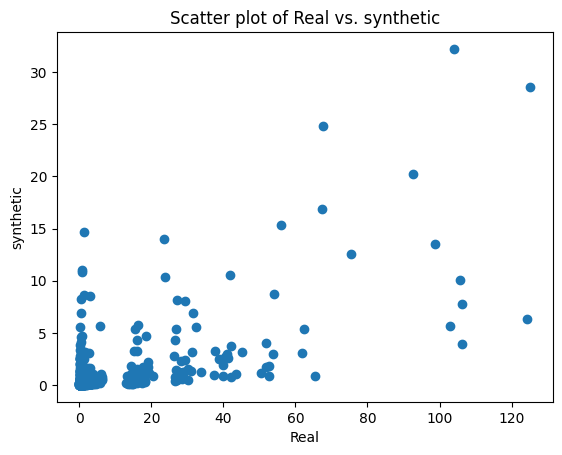

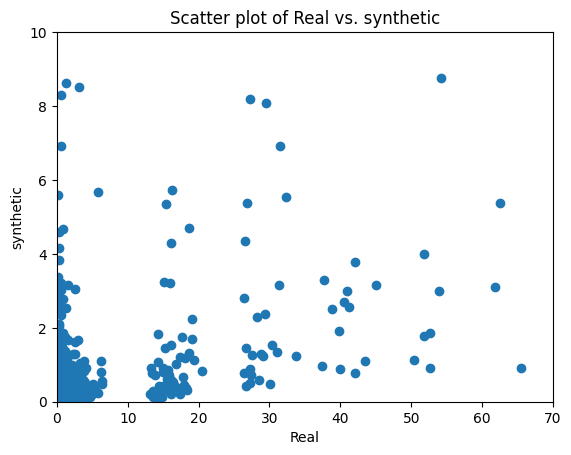

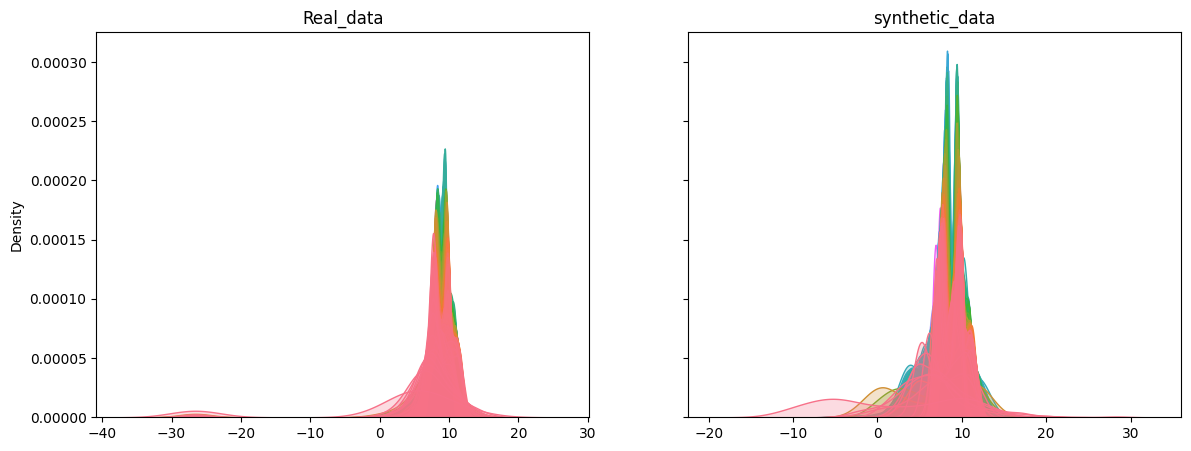

2000
Recall is: 1.0
Precision is: 0.975609756097561


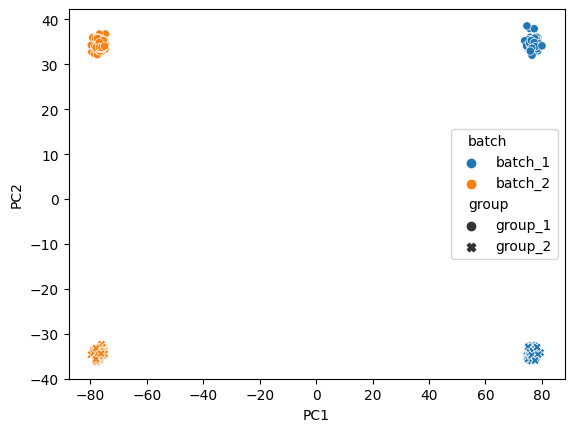

====> Epoch: 10 Average training loss: 5764.0227
====> Epoch: 10 Average test loss: 5906.6062
====> Epoch: 20 Average training loss: 5160.8260
====> Epoch: 20 Average test loss: 5516.1615
====> Epoch: 30 Average training loss: 5074.4097
====> Epoch: 30 Average test loss: 5453.0760
====> Epoch: 40 Average training loss: 5008.5605
====> Epoch: 40 Average test loss: 5384.8307
====> Epoch: 50 Average training loss: 4950.9832
====> Epoch: 50 Average test loss: 5320.6891
====> Epoch: 60 Average training loss: 4894.5255
====> Epoch: 60 Average test loss: 5269.1490
====> Epoch: 70 Average training loss: 4847.2614
====> Epoch: 70 Average test loss: 5219.8677
====> Epoch: 80 Average training loss: 4799.7672
====> Epoch: 80 Average test loss: 5178.4224
====> Epoch: 90 Average training loss: 4757.3422
====> Epoch: 90 Average test loss: 5135.9495
====> Epoch: 100 Average training loss: 4716.9661
====> Epoch: 100 Average test loss: 5101.9068
====> Epoch: 110 Average training loss: 4686.4021
====> Ep

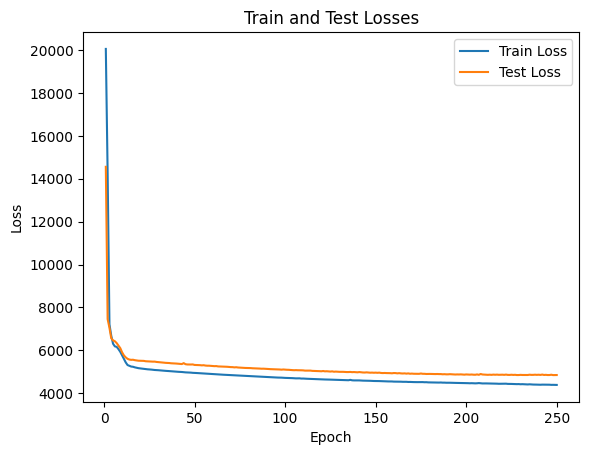

('Intersection of top 500 features (less than 0): ', 192)
('Intersection of top 1000 features (less than 0): ', 317)
('Intersection of top 2000 features (less than 0): ', 669)
('Intersection of top 4000 features (less than 0): ', 2012)
('Intersection of top 500 features (more than 0): ', 140)
('Intersection of top 1000 features (more than 0): ', 227)
('Intersection of top 2000 features (more than 0): ', 486)
('Intersection of top 4000 features (more than 0): ', 1880)


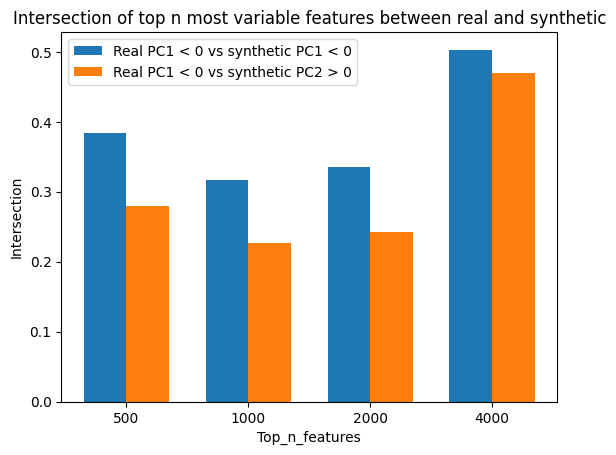

[296, 908, 1587, 1997]
[843, 1803, 2000, 2000]


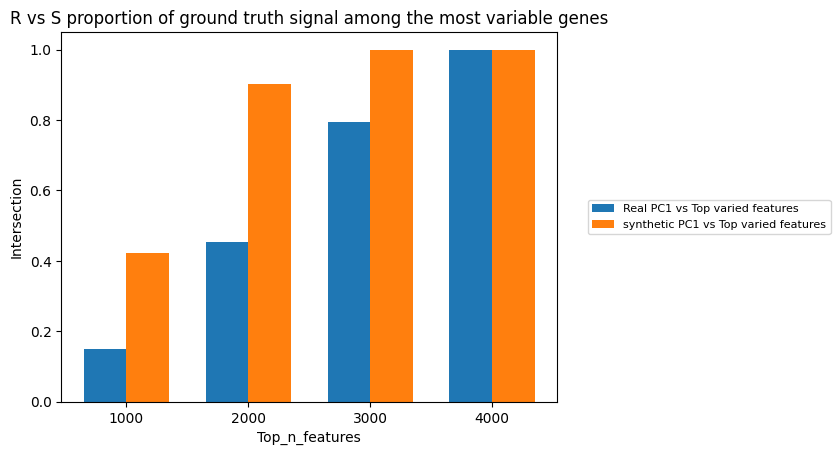

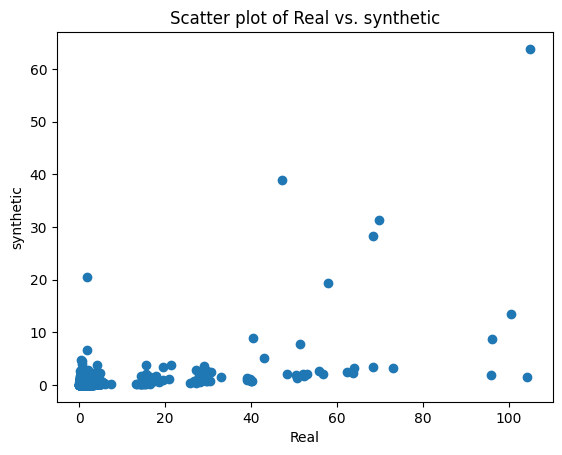

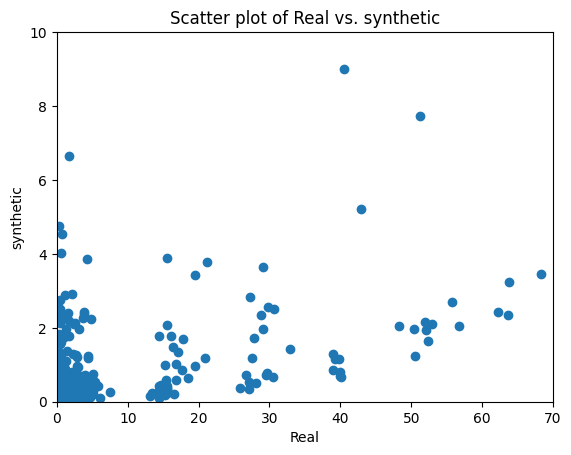

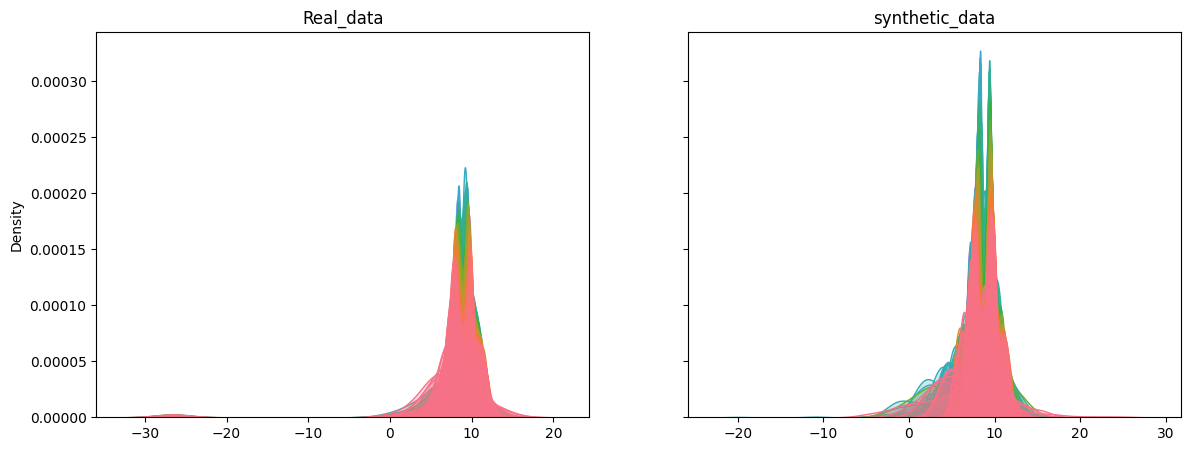

1984
Recall is: 0.992
Precision is: 0.9678048780487805


====> Epoch: 10 Average training loss: 5927.9836
====> Epoch: 10 Average test loss: 6071.3828
====> Epoch: 20 Average training loss: 5137.4073
====> Epoch: 20 Average test loss: 5453.8974
====> Epoch: 30 Average training loss: 5037.5443
====> Epoch: 30 Average test loss: 5401.0208
====> Epoch: 40 Average training loss: 4971.4378
====> Epoch: 40 Average test loss: 5338.5448
====> Epoch: 50 Average training loss: 4910.7255
====> Epoch: 50 Average test loss: 5279.3786
====> Epoch: 60 Average training loss: 4860.7731
====> Epoch: 60 Average test loss: 5222.0516
====> Epoch: 70 Average training loss: 4811.4124
====> Epoch: 70 Average test loss: 5171.7792
====> Epoch: 80 Average training loss: 4764.2463
====> Epoch: 80 Average test loss: 5124.1172
====> Epoch: 90 Average training loss: 4723.1492
====> Epoch: 90 Average test loss: 5086.4547
====> Epoch: 100 Average training loss: 4684.6252
====> Epoch: 100 Average test loss: 5053.4672
====> Epoch: 110 Average training loss: 4651.1687
====> Ep

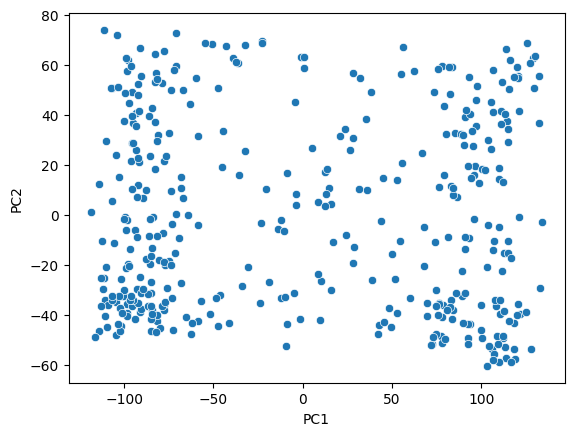

('Intersection of top 500 features (less than 0): ', 188)
('Intersection of top 1000 features (less than 0): ', 331)
('Intersection of top 2000 features (less than 0): ', 689)
('Intersection of top 4000 features (less than 0): ', 1935)
('Intersection of top 500 features (more than 0): ', 137)
('Intersection of top 1000 features (more than 0): ', 243)
('Intersection of top 2000 features (more than 0): ', 566)
('Intersection of top 4000 features (more than 0): ', 1796)


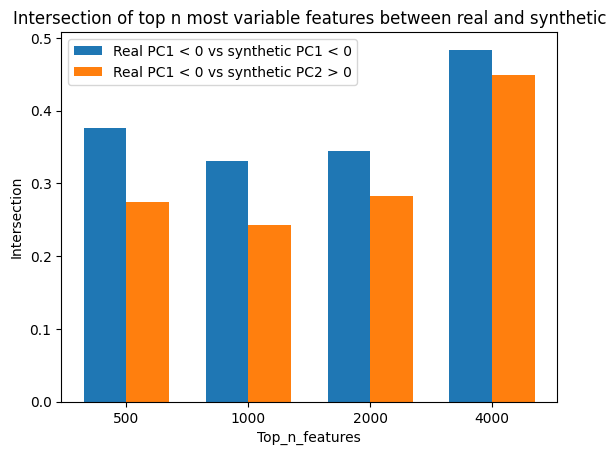

[336, 1004, 1638, 1999]
[873, 1841, 2000, 2000]


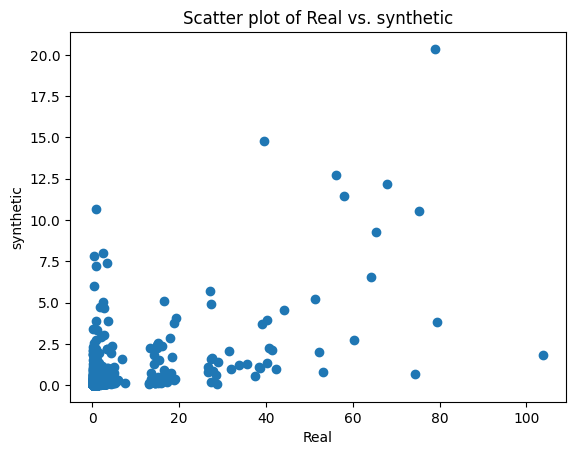

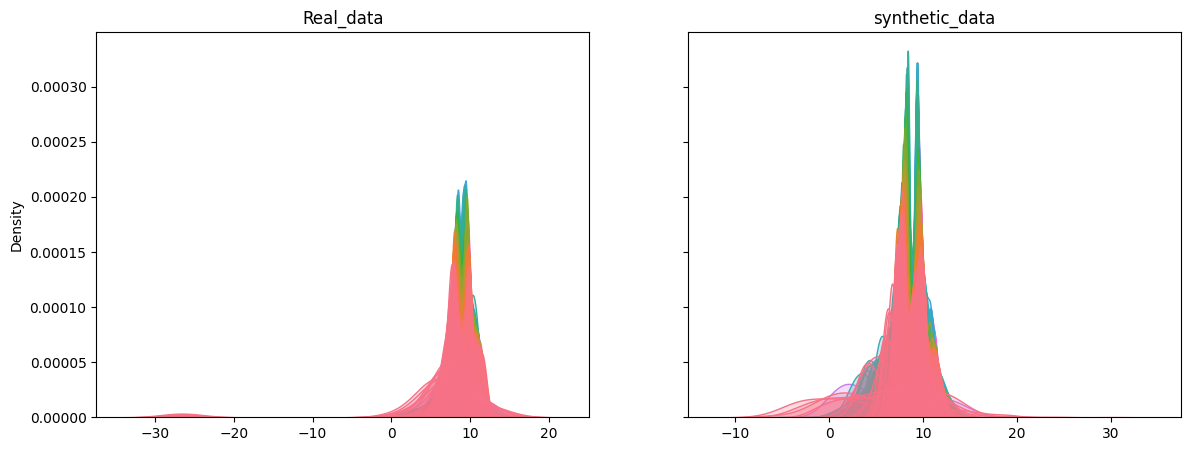

2000
Recall is: 1.0
Precision is: 0.975609756097561


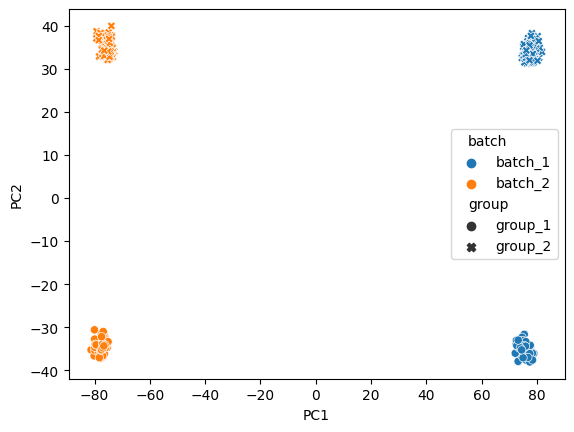

====> Epoch: 10 Average training loss: 5824.8227
====> Epoch: 10 Average test loss: 6012.4776
====> Epoch: 20 Average training loss: 5104.4958
====> Epoch: 20 Average test loss: 5404.2547
====> Epoch: 30 Average training loss: 5010.0977
====> Epoch: 30 Average test loss: 5356.9141
====> Epoch: 40 Average training loss: 4946.4402
====> Epoch: 40 Average test loss: 5295.3656
====> Epoch: 50 Average training loss: 4893.0971
====> Epoch: 50 Average test loss: 5237.4734
====> Epoch: 60 Average training loss: 4838.9343
====> Epoch: 60 Average test loss: 5185.9229
====> Epoch: 70 Average training loss: 4790.6981
====> Epoch: 70 Average test loss: 5139.9130
====> Epoch: 80 Average training loss: 4745.8391
====> Epoch: 80 Average test loss: 5088.9714
====> Epoch: 90 Average training loss: 4703.7067
====> Epoch: 90 Average test loss: 5045.6193
====> Epoch: 100 Average training loss: 4675.9972
====> Epoch: 100 Average test loss: 5017.6495
====> Epoch: 110 Average training loss: 4629.7682
====> Ep

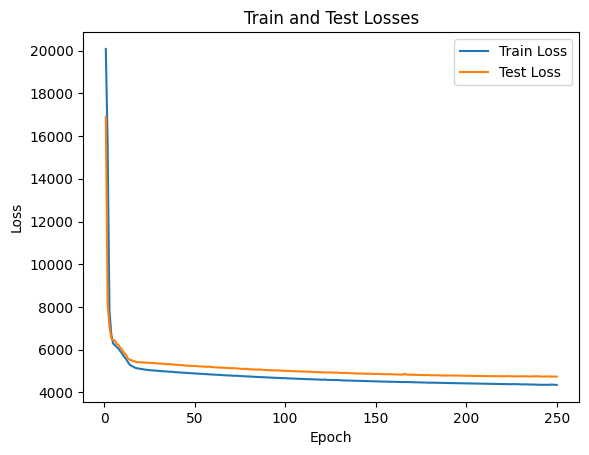

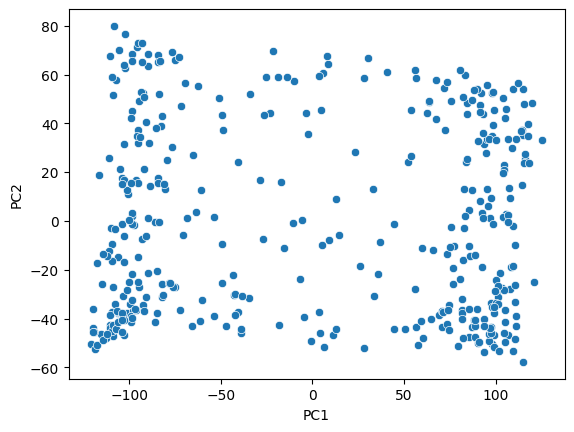

('Intersection of top 500 features (less than 0): ', 165)
('Intersection of top 1000 features (less than 0): ', 283)
('Intersection of top 2000 features (less than 0): ', 612)
('Intersection of top 4000 features (less than 0): ', 1889)
('Intersection of top 500 features (more than 0): ', 160)
('Intersection of top 1000 features (more than 0): ', 259)
('Intersection of top 2000 features (more than 0): ', 585)
('Intersection of top 4000 features (more than 0): ', 1859)


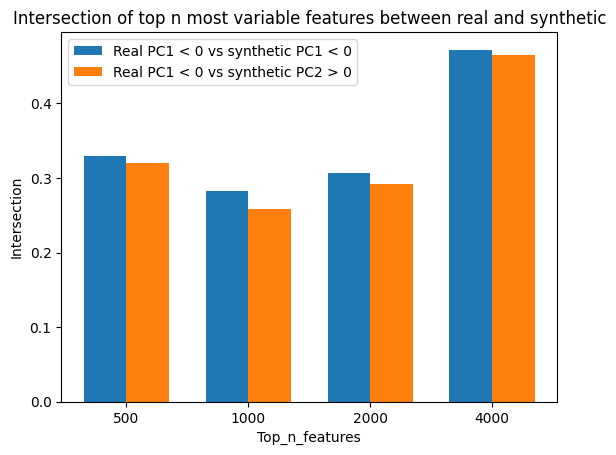

[350, 1011, 1671, 1999]
[866, 1840, 2000, 2000]


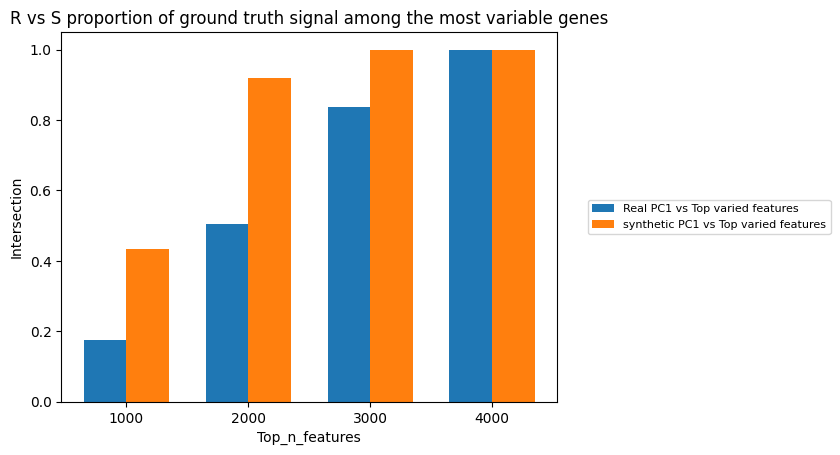

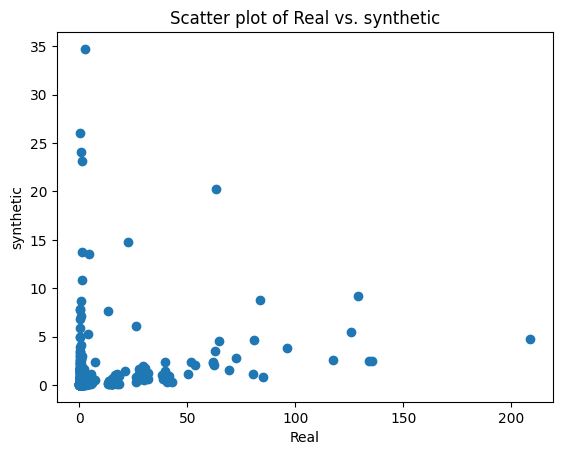

1998
Recall is: 0.999
Precision is: 0.9746341463414634


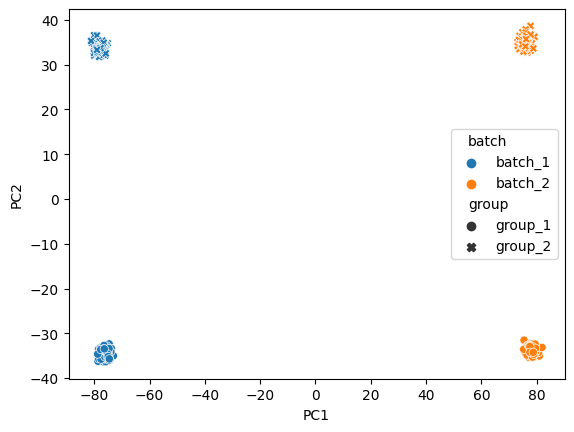

====> Epoch: 10 Average training loss: 5802.3901
====> Epoch: 10 Average test loss: 5984.2531
====> Epoch: 20 Average training loss: 5074.9106
====> Epoch: 20 Average test loss: 5392.5484
====> Epoch: 30 Average training loss: 4966.0254
====> Epoch: 30 Average test loss: 5329.6240
====> Epoch: 40 Average training loss: 4903.6344
====> Epoch: 40 Average test loss: 5269.3005
====> Epoch: 50 Average training loss: 4845.7850
====> Epoch: 50 Average test loss: 5211.4479
====> Epoch: 60 Average training loss: 4790.9444
====> Epoch: 60 Average test loss: 5160.5396
====> Epoch: 70 Average training loss: 4740.6669
====> Epoch: 70 Average test loss: 5112.3328
====> Epoch: 80 Average training loss: 4698.6053
====> Epoch: 80 Average test loss: 5065.0266
====> Epoch: 90 Average training loss: 4656.7041
====> Epoch: 90 Average test loss: 5026.1859
====> Epoch: 100 Average training loss: 4621.0671
====> Epoch: 100 Average test loss: 4991.1417
====> Epoch: 110 Average training loss: 4586.1804
====> Ep

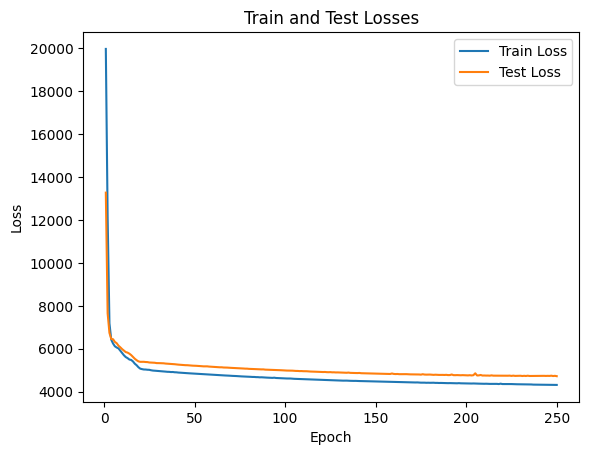

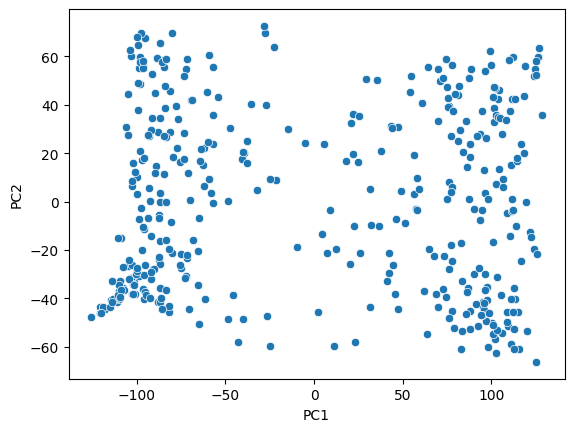

('Intersection of top 500 features (less than 0): ', 200)
('Intersection of top 1000 features (less than 0): ', 315)
('Intersection of top 2000 features (less than 0): ', 641)
('Intersection of top 4000 features (less than 0): ', 1999)
('Intersection of top 500 features (more than 0): ', 157)
('Intersection of top 1000 features (more than 0): ', 247)
('Intersection of top 2000 features (more than 0): ', 574)
('Intersection of top 4000 features (more than 0): ', 1898)


[346, 999, 1685, 2000]
[886, 1860, 2000, 2000]


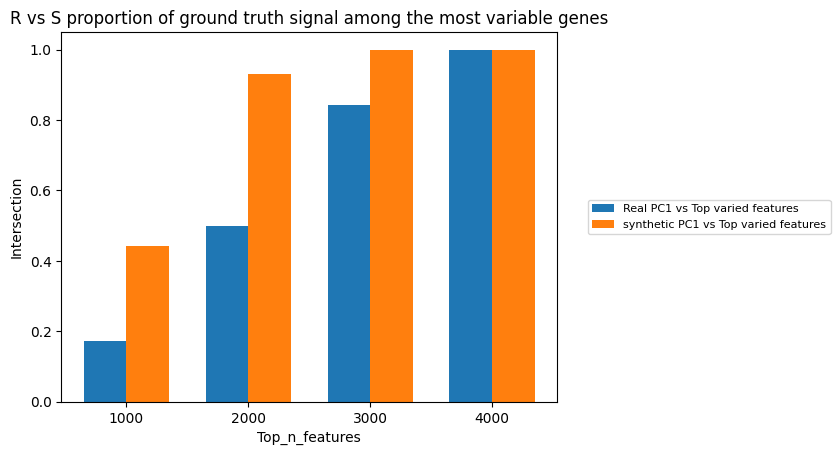

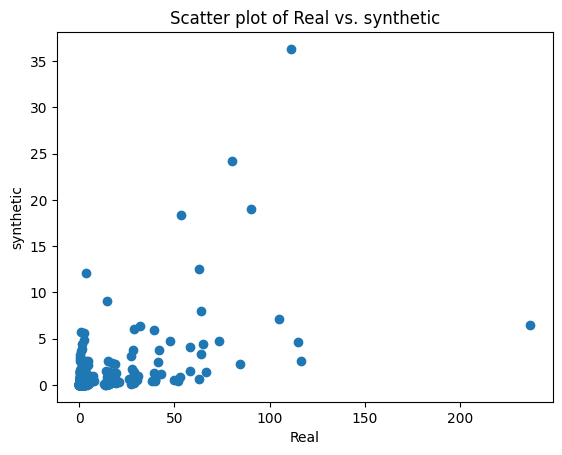

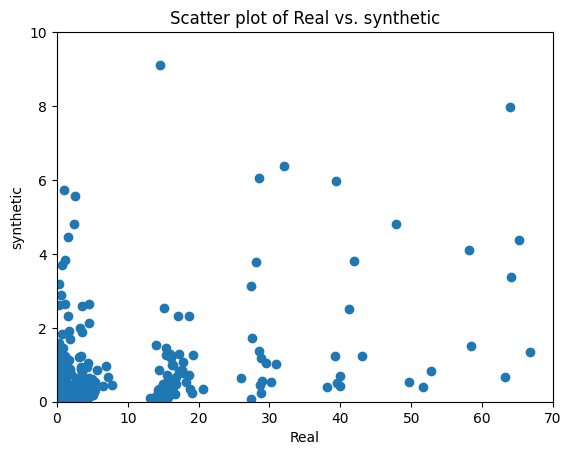

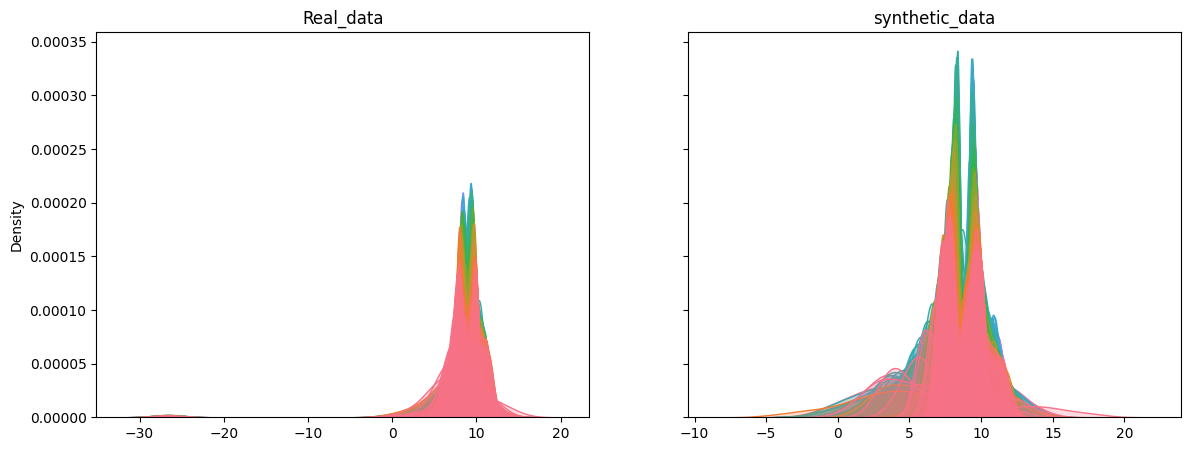

1996
Recall is: 0.998
Precision is: 0.9736585365853658


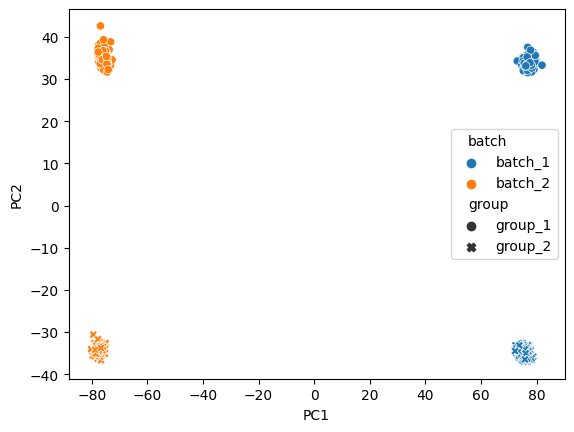

====> Epoch: 10 Average training loss: 5413.6759
====> Epoch: 10 Average test loss: 5593.2896
====> Epoch: 20 Average training loss: 5111.1399
====> Epoch: 20 Average test loss: 5415.4266
====> Epoch: 30 Average training loss: 5034.8095
====> Epoch: 30 Average test loss: 5356.9068
====> Epoch: 40 Average training loss: 4966.4597
====> Epoch: 40 Average test loss: 5281.3036
====> Epoch: 50 Average training loss: 4913.4141
====> Epoch: 50 Average test loss: 5235.5172
====> Epoch: 60 Average training loss: 4855.8963
====> Epoch: 60 Average test loss: 5173.1396
====> Epoch: 70 Average training loss: 4808.1511
====> Epoch: 70 Average test loss: 5122.0448
====> Epoch: 80 Average training loss: 4761.8891
====> Epoch: 80 Average test loss: 5083.2188
====> Epoch: 90 Average training loss: 4720.7449
====> Epoch: 90 Average test loss: 5035.3458
====> Epoch: 100 Average training loss: 4680.3367
====> Epoch: 100 Average test loss: 5005.9609
====> Epoch: 110 Average training loss: 4645.9478
====> Ep

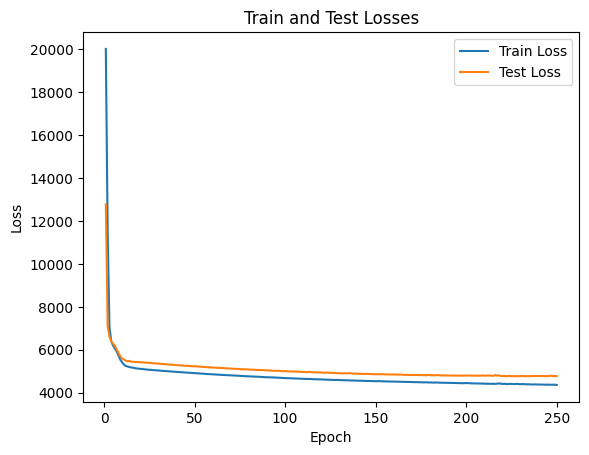

('Intersection of top 500 features (less than 0): ', 195)
('Intersection of top 1000 features (less than 0): ', 320)
('Intersection of top 2000 features (less than 0): ', 658)
('Intersection of top 4000 features (less than 0): ', 1910)
('Intersection of top 500 features (more than 0): ', 141)
('Intersection of top 1000 features (more than 0): ', 242)
('Intersection of top 2000 features (more than 0): ', 538)
('Intersection of top 4000 features (more than 0): ', 1828)


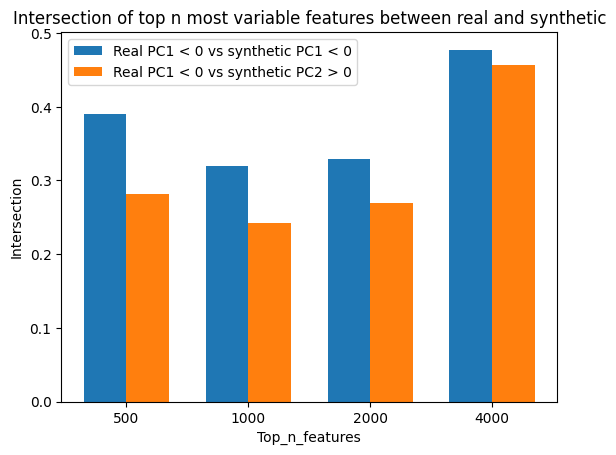

[322, 952, 1644, 2000]
[871, 1839, 2000, 2000]


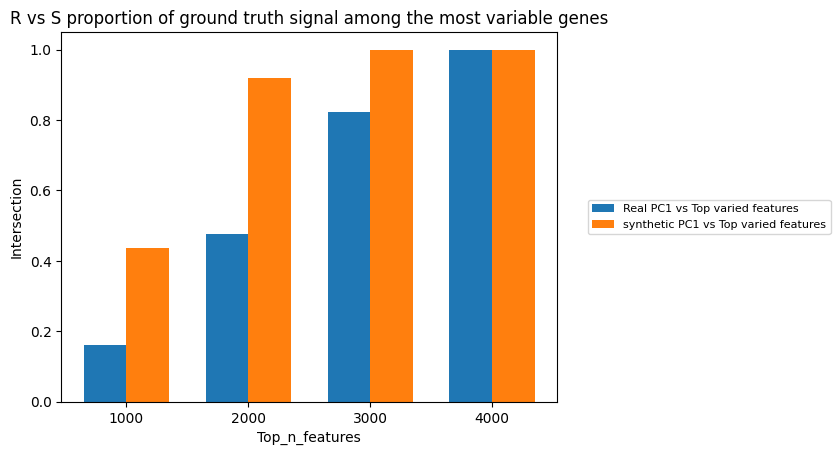

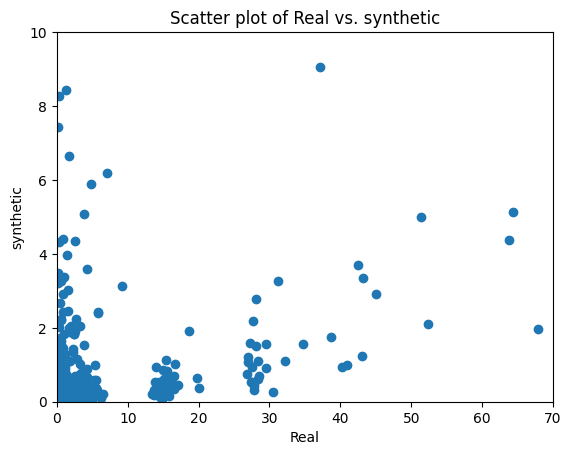

1997
Recall is: 0.9985
Precision is: 0.9741463414634146


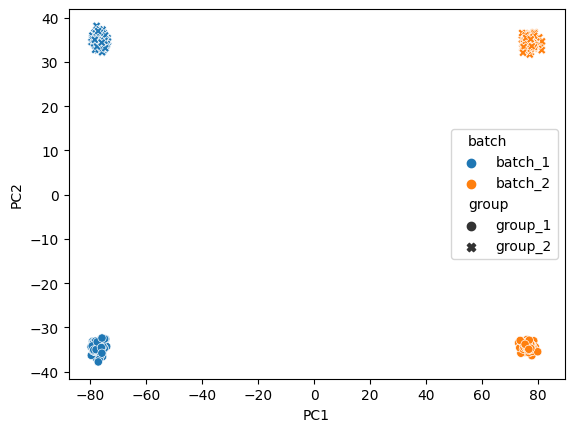

====> Epoch: 10 Average training loss: 5678.6236
====> Epoch: 10 Average test loss: 5893.8182
====> Epoch: 20 Average training loss: 5148.9939
====> Epoch: 20 Average test loss: 5546.4656
====> Epoch: 30 Average training loss: 5054.8482
====> Epoch: 30 Average test loss: 5492.8786
====> Epoch: 40 Average training loss: 4991.0229
====> Epoch: 40 Average test loss: 5428.6708
====> Epoch: 50 Average training loss: 4935.4478
====> Epoch: 50 Average test loss: 5366.9401
====> Epoch: 60 Average training loss: 4878.5278
====> Epoch: 60 Average test loss: 5314.6641
====> Epoch: 70 Average training loss: 4831.9382
====> Epoch: 70 Average test loss: 5266.7552
====> Epoch: 80 Average training loss: 4782.6330
====> Epoch: 80 Average test loss: 5218.7495
====> Epoch: 90 Average training loss: 4740.0804
====> Epoch: 90 Average test loss: 5171.4339
====> Epoch: 100 Average training loss: 4701.8608
====> Epoch: 100 Average test loss: 5142.6891
====> Epoch: 110 Average training loss: 4671.1683
====> Ep

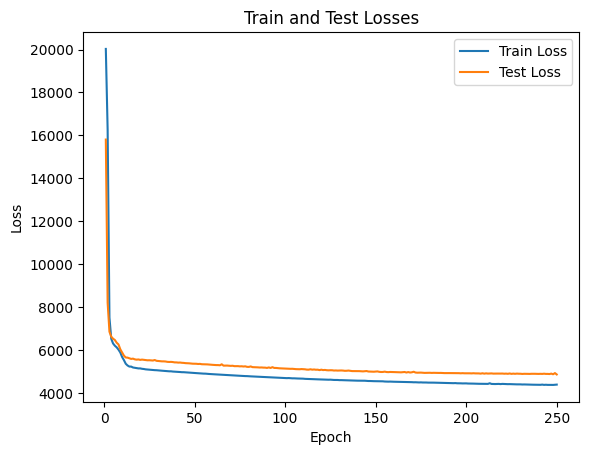

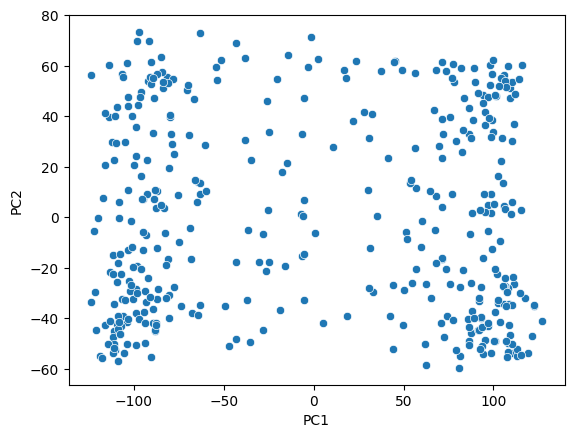

('Intersection of top 500 features (less than 0): ', 206)
('Intersection of top 1000 features (less than 0): ', 332)
('Intersection of top 2000 features (less than 0): ', 693)
('Intersection of top 4000 features (less than 0): ', 1982)
('Intersection of top 500 features (more than 0): ', 146)
('Intersection of top 1000 features (more than 0): ', 203)
('Intersection of top 2000 features (more than 0): ', 572)
('Intersection of top 4000 features (more than 0): ', 1902)


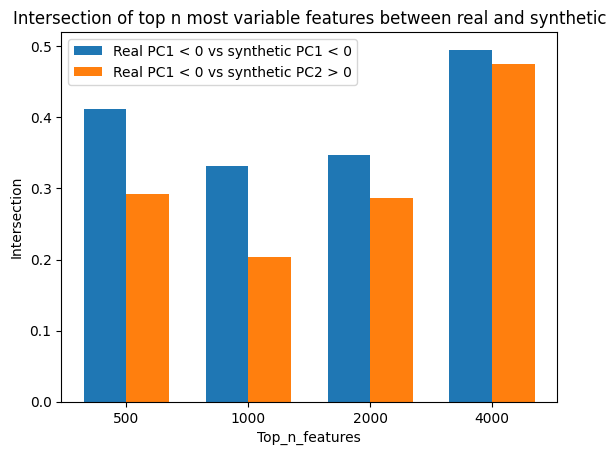

[322, 958, 1637, 1997]
[842, 1815, 2000, 2000]


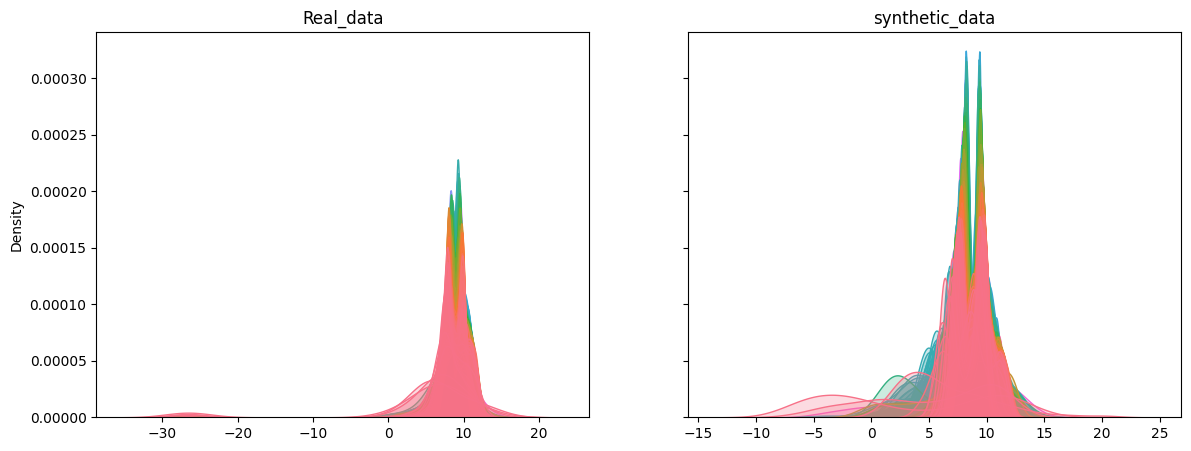

1994
Recall is: 0.997
Precision is: 0.9726829268292683


'Successfully trained'

In [ ]:
train_variational_autoencoder()

2/2 [==============================] - 3s 9ms/step
Epoch 1/1000 - Discriminator Loss: 7.552129305899143 - Generator Loss: 13.89871883392334
2/2 [==============================] - 0s 10ms/step
Epoch 2/1000 - Discriminator Loss: 2.049954414367676 - Generator Loss: 8.688441276550293
2/2 [==============================] - 0s 8ms/step
Epoch 3/1000 - Discriminator Loss: 0.251336008310318 - Generator Loss: 8.194503784179688
2/2 [==============================] - 0s 11ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 6.989429950714111
2/2 [==============================] - 0s 10ms/step
Epoch 5/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.832982063293457
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 6.989429473876953
2/2 [==============================] - 0s 7ms/step
Epoch 7/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.59196662902832
2/2 [==============================] - 0s 7ms/step
Epoch 8/1000 - Discrimi

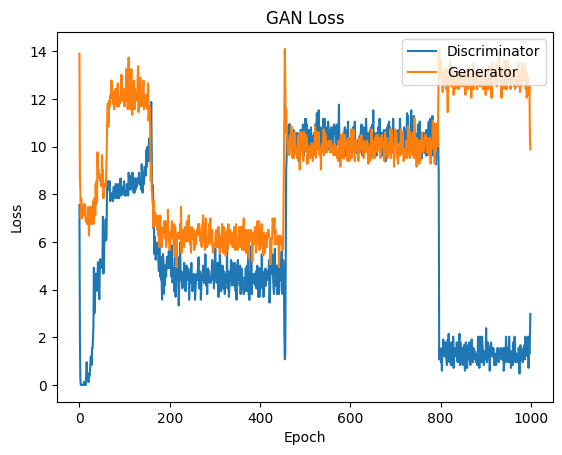

13/13 [==============================] - 0s 5ms/step


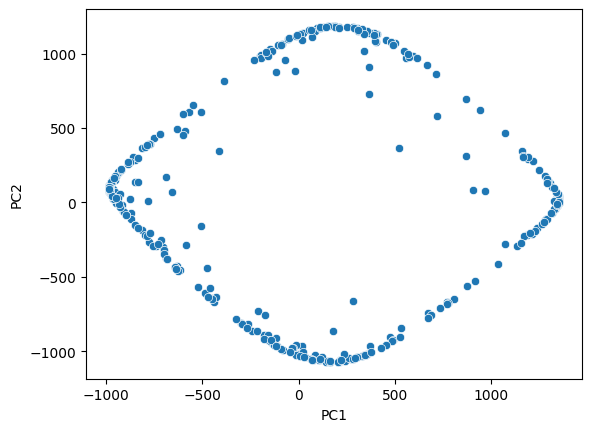

('Intersection of top 500 features (less than 0): ', 94)
('Intersection of top 1000 features (less than 0): ', 168)
('Intersection of top 2000 features (less than 0): ', 453)
('Intersection of top 4000 features (less than 0): ', 1588)
('Intersection of top 500 features (more than 0): ', 92)
('Intersection of top 1000 features (more than 0): ', 182)
('Intersection of top 2000 features (more than 0): ', 470)
('Intersection of top 4000 features (more than 0): ', 1666)


[320, 981, 1665, 1999]
[379, 666, 896, 1115]


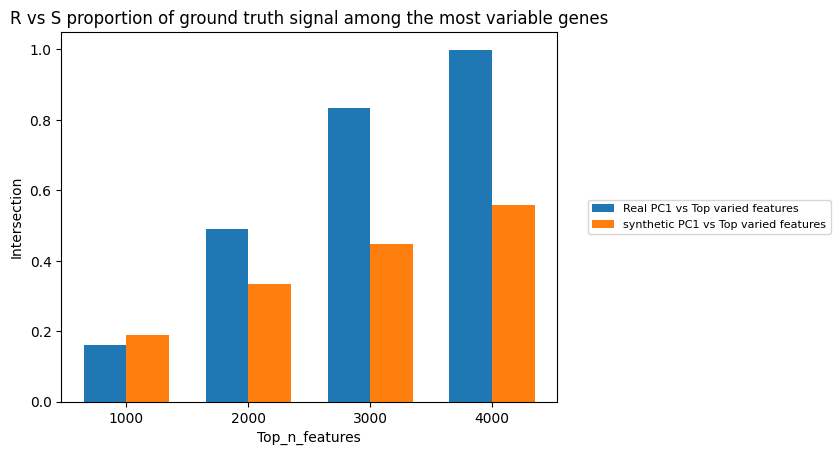

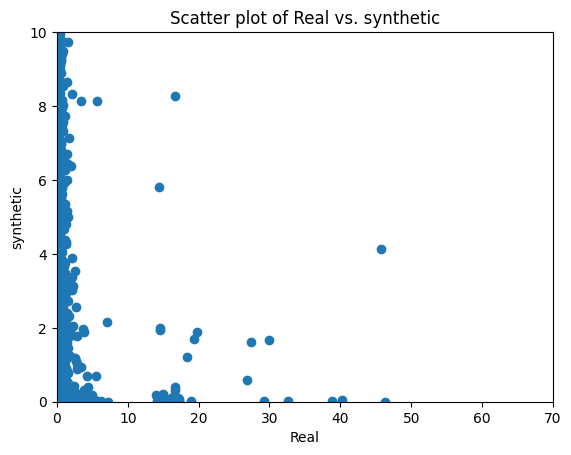

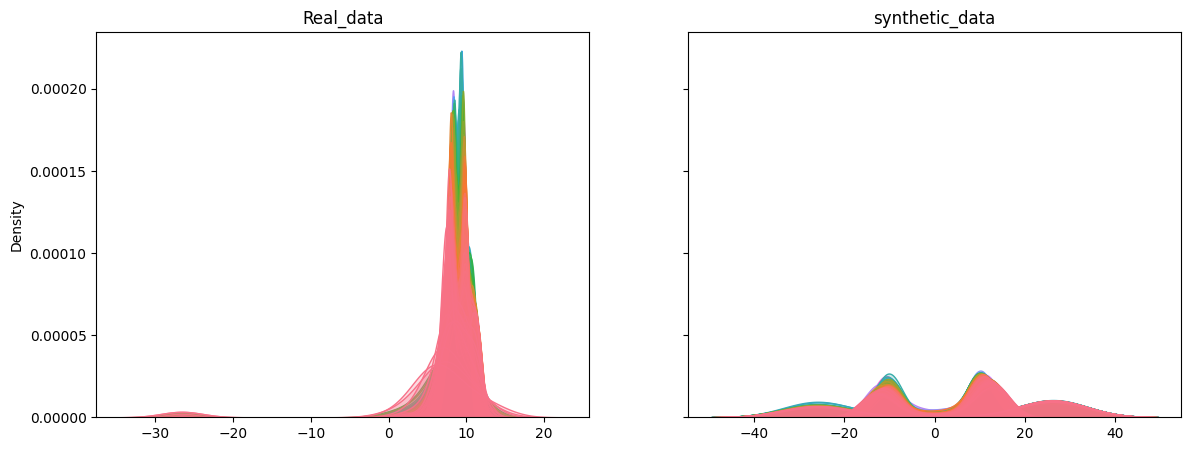

506
Recall is: 0.253
Precision is: 0.24682926829268292


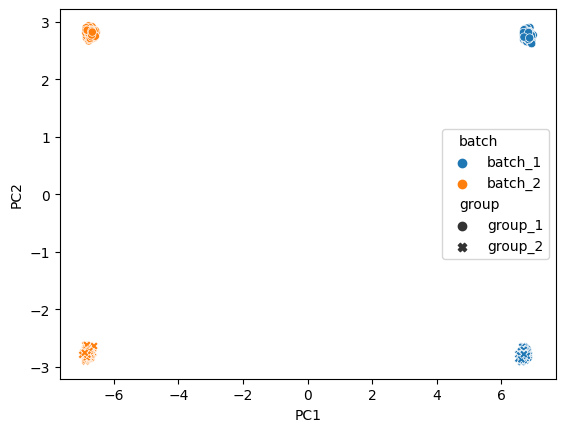

2/2 [==============================] - 0s 7ms/step
Epoch 1/1000 - Discriminator Loss: 3.781153380870819 - Generator Loss: 6.958637237548828
2/2 [==============================] - 0s 9ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 6.764939785003662
2/2 [==============================] - 0s 12ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.013831615447998
2/2 [==============================] - 0s 8ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 8.315982818603516
2/2 [==============================] - 0s 9ms/step
Epoch 5/1000 - Discriminator Loss: 0.0 - Generator Loss: 6.868922233581543
2/2 [==============================] - 0s 10ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.471582412719727
2/2 [==============================] - 0s 6ms/step
Epoch 7/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.23044490814209
2/2 [==============================] - 0s 6ms/step
Epoch 8/1000 - Discriminator Loss: 0.0 - Generator L

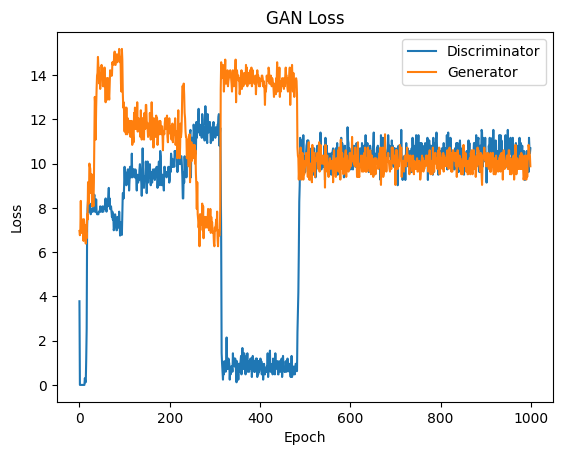

13/13 [==============================] - 0s 4ms/step


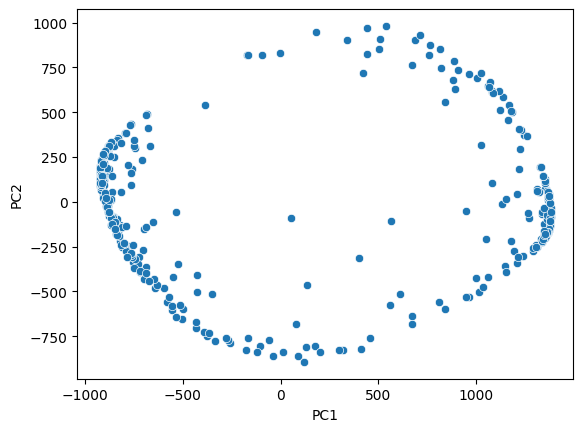

('Intersection of top 500 features (less than 0): ', 92)
('Intersection of top 1000 features (less than 0): ', 169)
('Intersection of top 2000 features (less than 0): ', 451)
('Intersection of top 4000 features (less than 0): ', 1670)
('Intersection of top 500 features (more than 0): ', 93)
('Intersection of top 1000 features (more than 0): ', 154)
('Intersection of top 2000 features (more than 0): ', 420)
('Intersection of top 4000 features (more than 0): ', 1619)


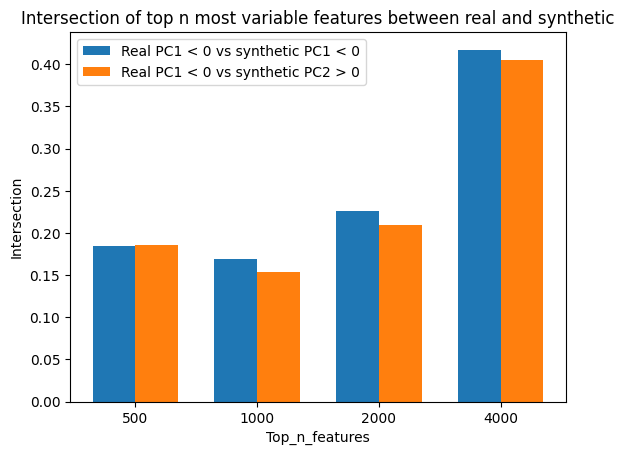

[332, 986, 1658, 2000]
[256, 468, 679, 894]


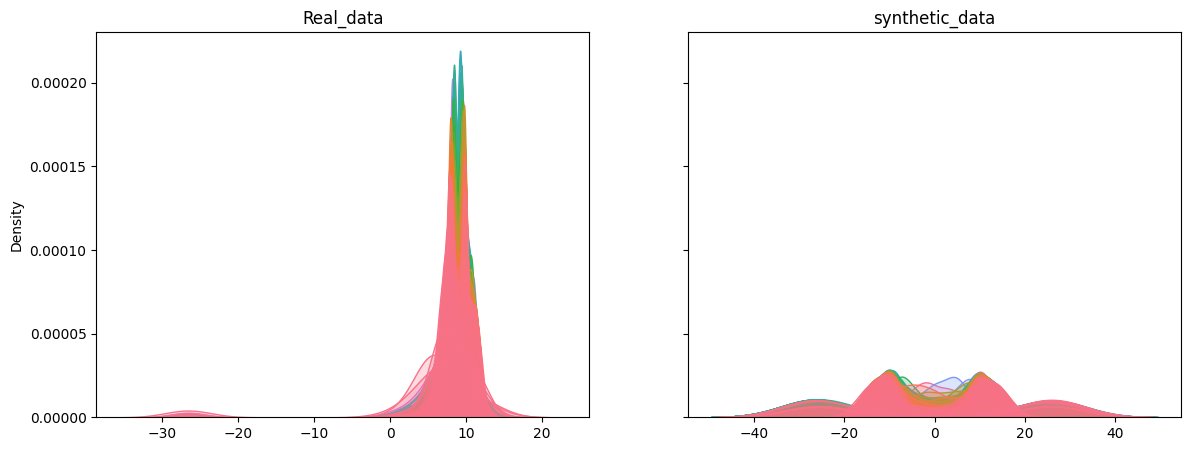

433
Recall is: 0.2165
Precision is: 0.21121951219512194


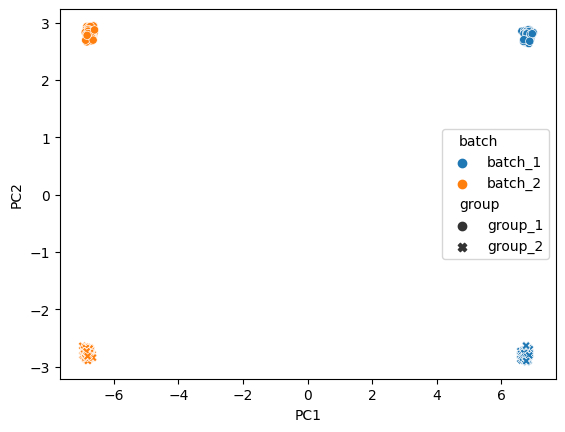

2/2 [==============================] - 0s 6ms/step
Epoch 1/1000 - Discriminator Loss: 2.340964823961258 - Generator Loss: 7.790031433105469
2/2 [==============================] - 0s 8ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.233041286468506
2/2 [==============================] - 0s 12ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.954111576080322
2/2 [==============================] - 0s 6ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 8.073995590209961
2/2 [==============================] - 0s 14ms/step
Epoch 5/1000 - Discriminator Loss: 0.12050741165876389 - Generator Loss: 7.953489303588867
2/2 [==============================] - 0s 11ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.832982063293457
2/2 [==============================] - 0s 5ms/step
Epoch 7/1000 - Discriminator Loss: 0.24101482331752777 - Generator Loss: 7.832981109619141
2/2 [==============================] - 0s 7ms/step
Epoch 8/1000 - Dis

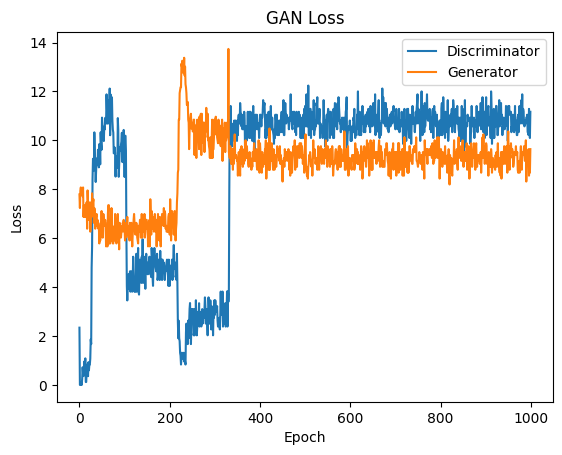

13/13 [==============================] - 0s 4ms/step


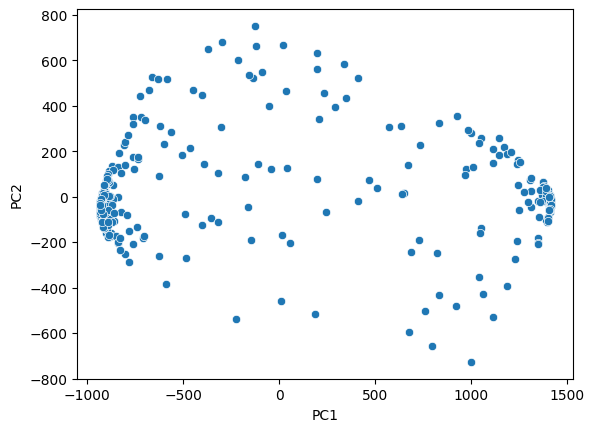

('Intersection of top 500 features (less than 0): ', 85)
('Intersection of top 1000 features (less than 0): ', 190)
('Intersection of top 2000 features (less than 0): ', 487)
('Intersection of top 4000 features (less than 0): ', 1720)
('Intersection of top 500 features (more than 0): ', 91)
('Intersection of top 1000 features (more than 0): ', 186)
('Intersection of top 2000 features (more than 0): ', 498)
('Intersection of top 4000 features (more than 0): ', 1680)


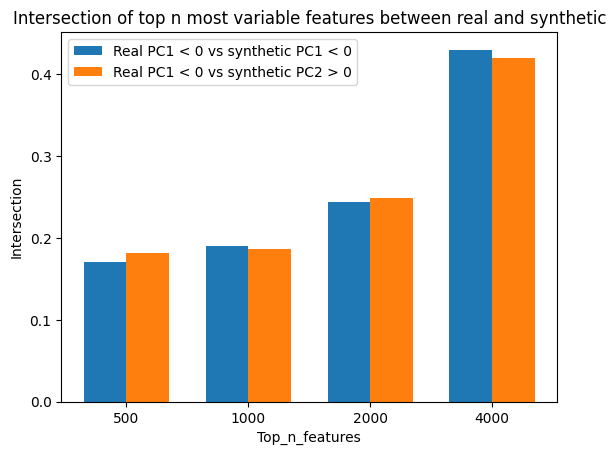

[372, 1018, 1691, 2000]
[252, 430, 675, 936]


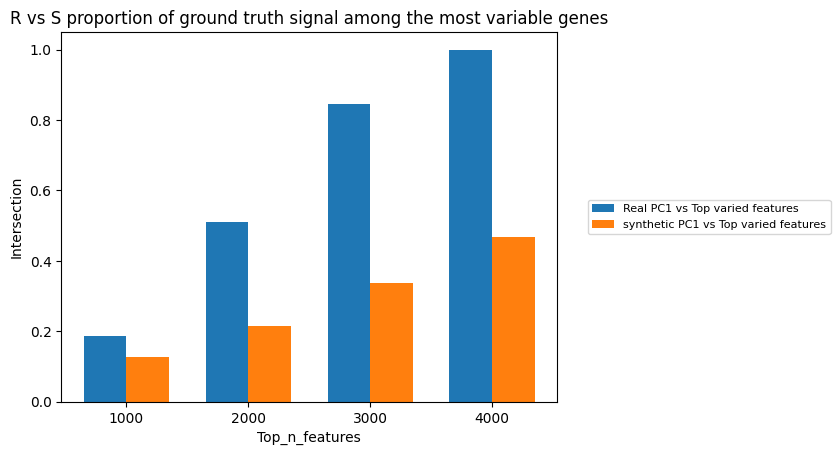

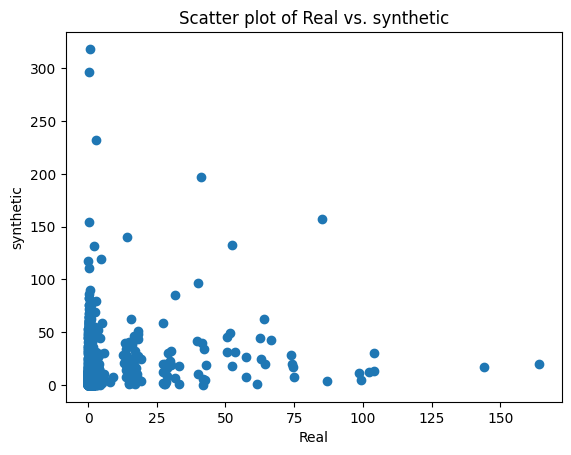

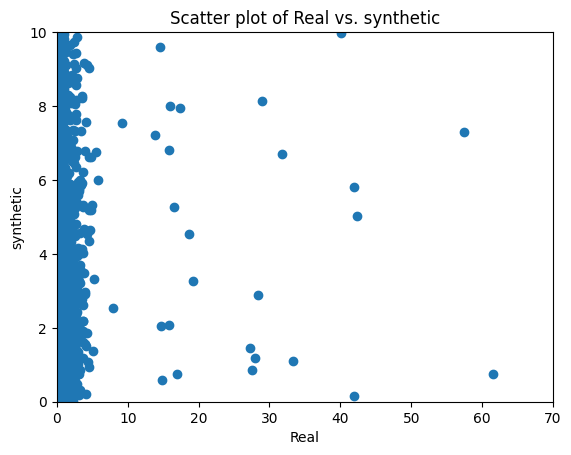

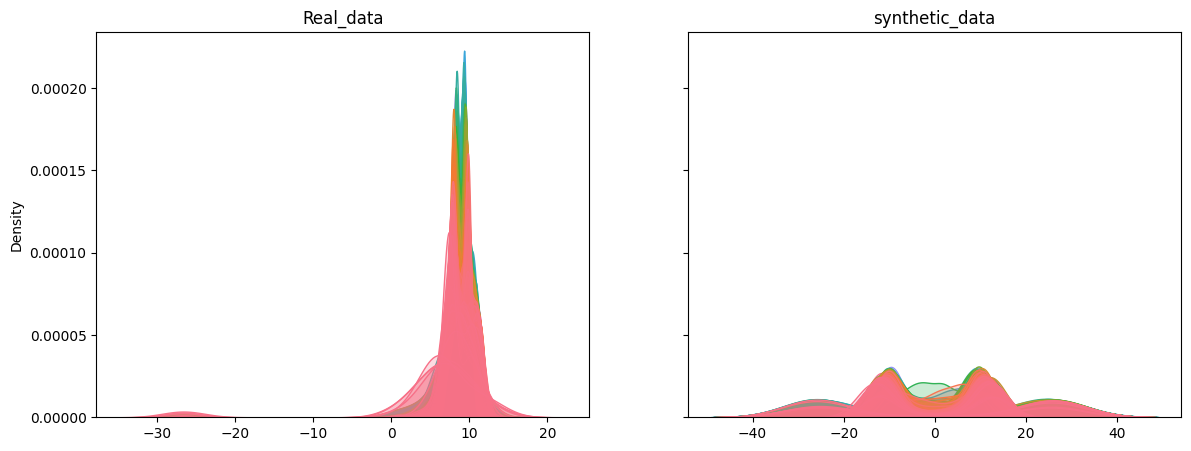

416
Recall is: 0.208
Precision is: 0.2029268292682927


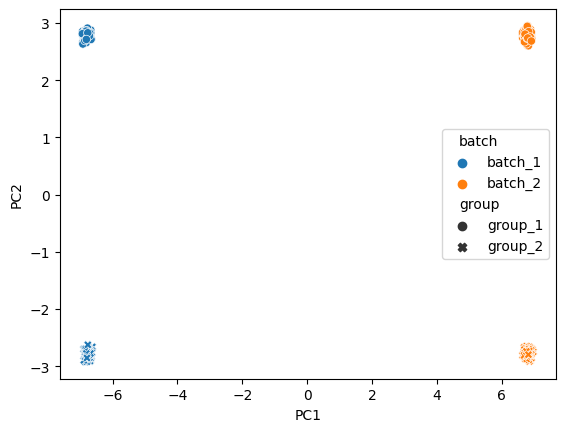

2/2 [==============================] - 0s 10ms/step
Epoch 1/1000 - Discriminator Loss: 3.841840535402298 - Generator Loss: 7.163214683532715
2/2 [==============================] - 0s 8ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.857077121734619
2/2 [==============================] - 0s 5ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.47385311126709
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.10993766784668
2/2 [==============================] - 0s 14ms/step
Epoch 5/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.832982063293457
2/2 [==============================] - 0s 9ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 6.989429473876953
2/2 [==============================] - 0s 12ms/step
Epoch 7/1000 - Discriminator Loss: 0.12050741165876389 - Generator Loss: 7.953489303588867
2/2 [==============================] - 0s 12ms/step
Epoch 8/1000 - Discriminator Loss: 

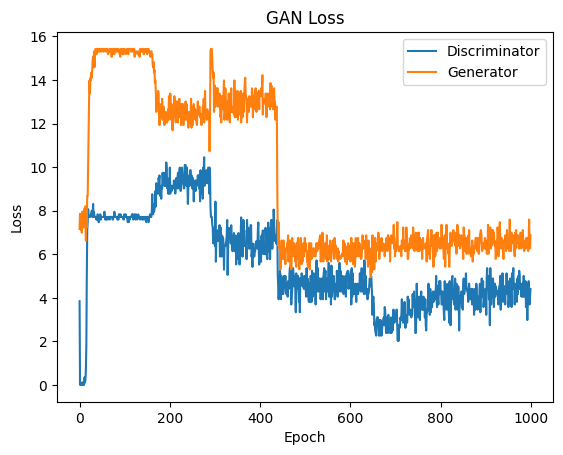

13/13 [==============================] - 0s 5ms/step


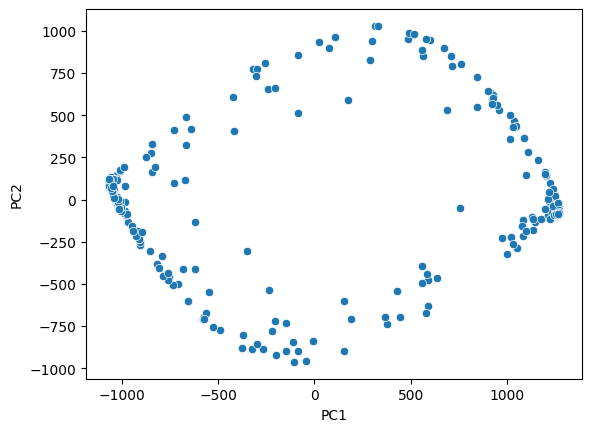

('Intersection of top 500 features (less than 0): ', 97)
('Intersection of top 1000 features (less than 0): ', 179)
('Intersection of top 2000 features (less than 0): ', 461)
('Intersection of top 4000 features (less than 0): ', 1627)
('Intersection of top 500 features (more than 0): ', 95)
('Intersection of top 1000 features (more than 0): ', 171)
('Intersection of top 2000 features (more than 0): ', 459)
('Intersection of top 4000 features (more than 0): ', 1656)


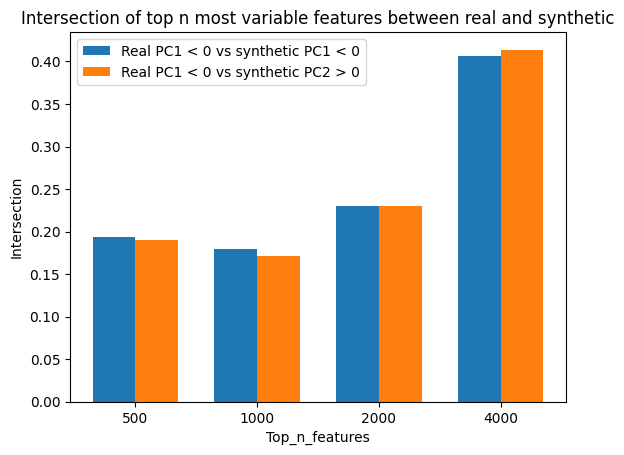

[319, 970, 1615, 1996]
[313, 497, 705, 959]


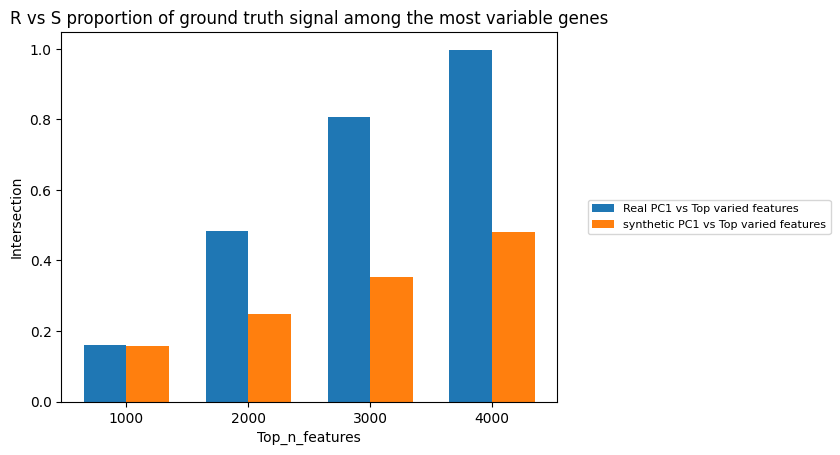

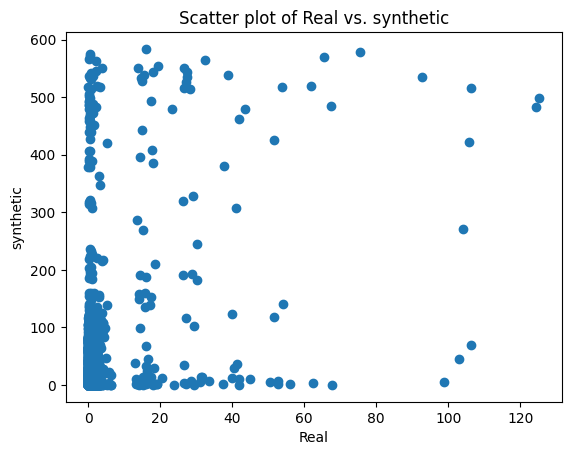

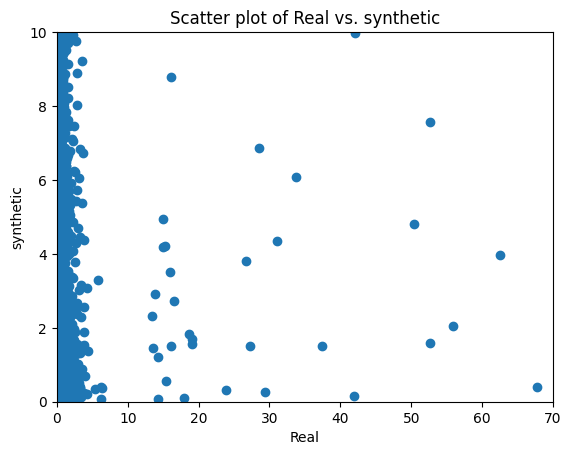

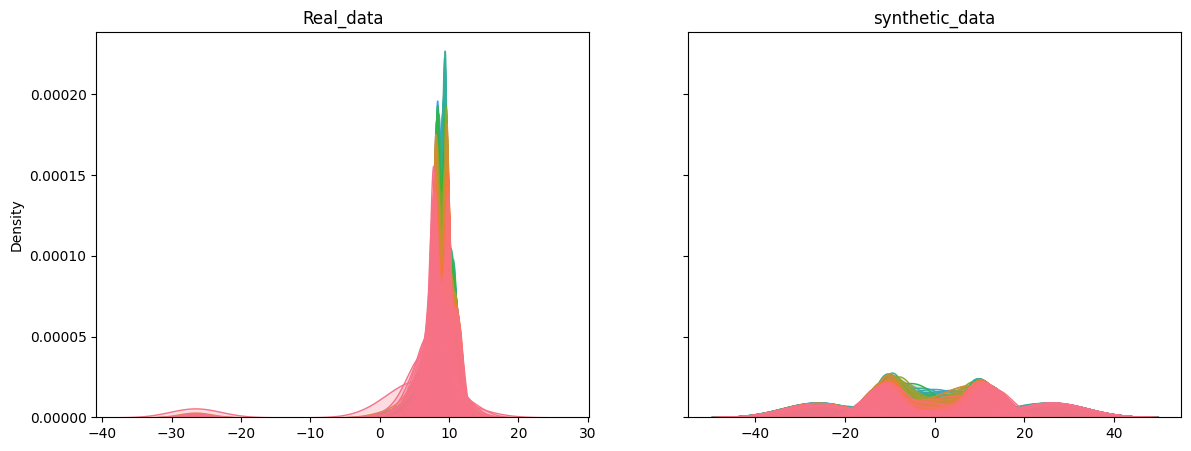

470
Recall is: 0.235
Precision is: 0.22926829268292684


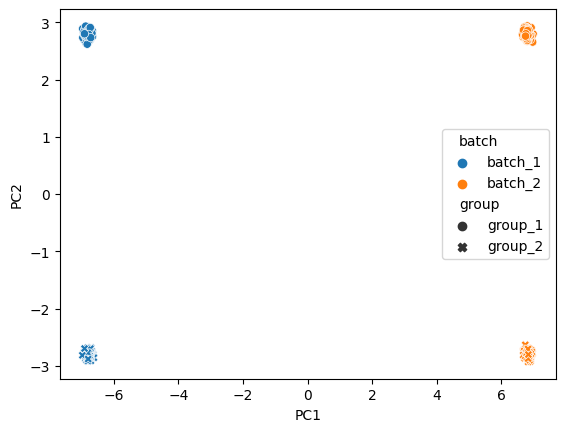

2/2 [==============================] - 0s 10ms/step
Epoch 1/1000 - Discriminator Loss: 6.278109706938267 - Generator Loss: 9.242258071899414
2/2 [==============================] - 0s 6ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.720371246337891
2/2 [==============================] - 0s 7ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.71360969543457
2/2 [==============================] - 0s 8ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.953596115112305
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 - Discriminator Loss: 0.4892805814743042 - Generator Loss: 8.19462776184082
2/2 [==============================] - 0s 6ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.8329901695251465
2/2 [==============================] - 0s 5ms/step
Epoch 7/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.23044490814209
2/2 [==============================] - 0s 8ms/step
Epoch 8/1000 - Discriminator Loss: 0.0 

13/13 [==============================] - 0s 6ms/step


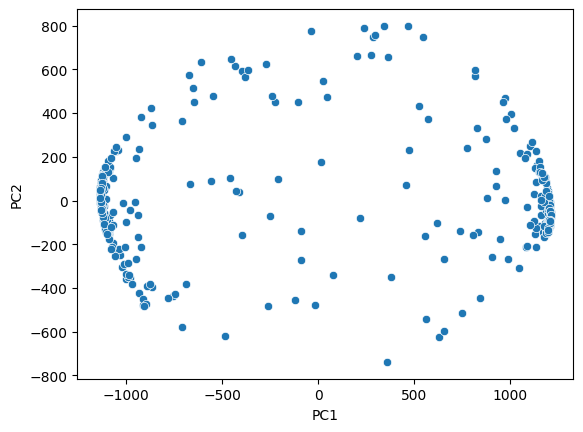

('Intersection of top 500 features (less than 0): ', 101)
('Intersection of top 1000 features (less than 0): ', 202)
('Intersection of top 2000 features (less than 0): ', 505)
('Intersection of top 4000 features (less than 0): ', 1738)
('Intersection of top 500 features (more than 0): ', 82)
('Intersection of top 1000 features (more than 0): ', 160)
('Intersection of top 2000 features (more than 0): ', 471)
('Intersection of top 4000 features (more than 0): ', 1619)


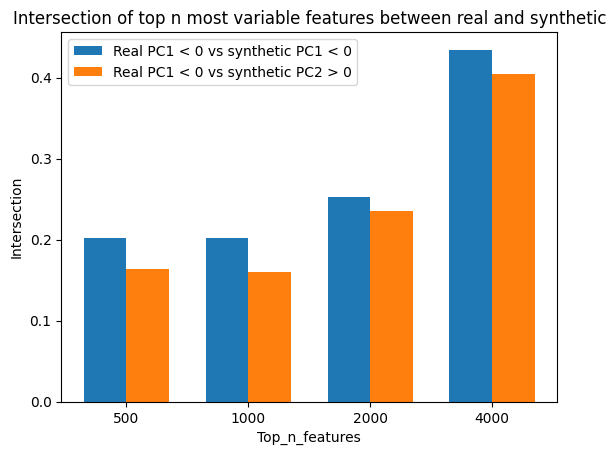

[320, 953, 1614, 1997]
[241, 488, 730, 972]


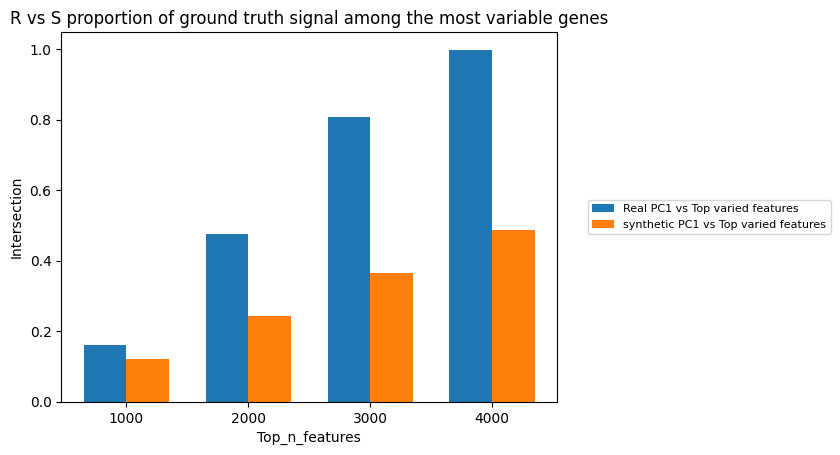

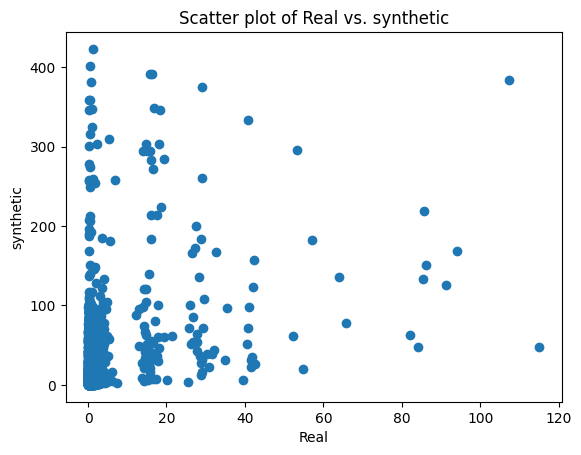

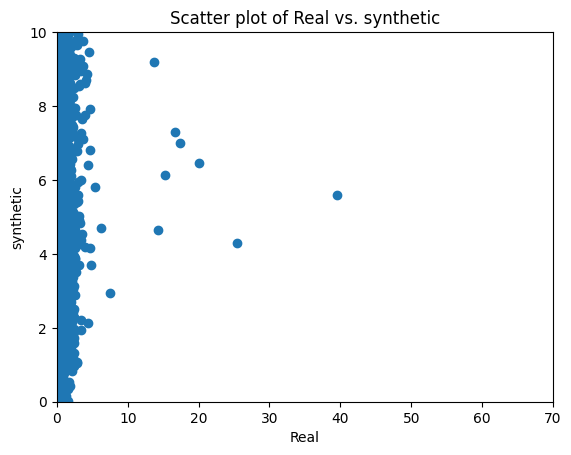

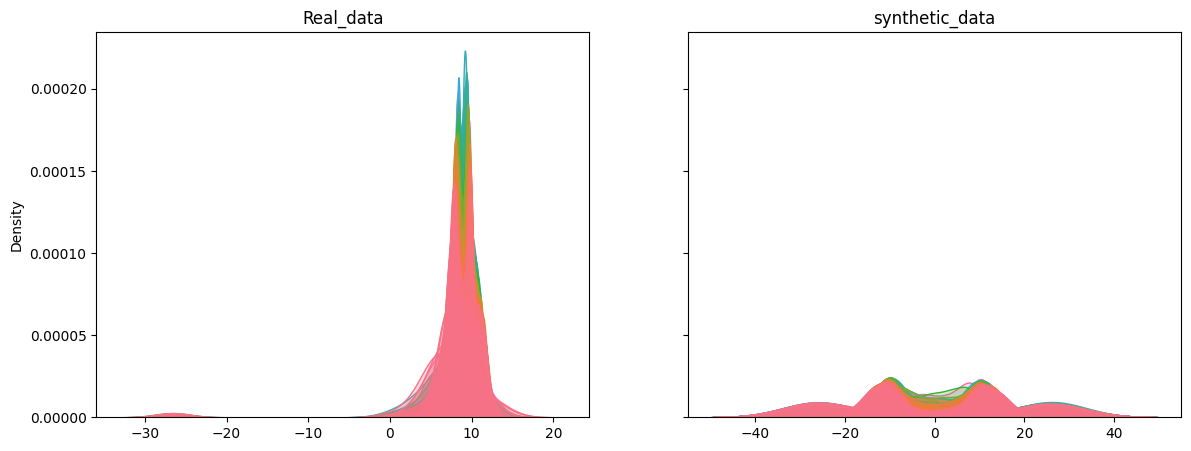

448
Recall is: 0.224
Precision is: 0.21853658536585366


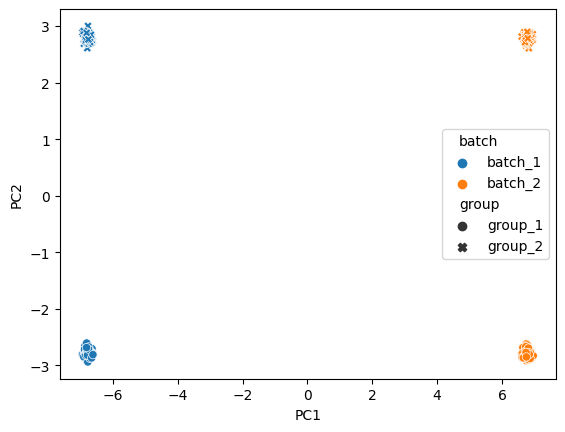

2/2 [==============================] - 0s 15ms/step
Epoch 1/1000 - Discriminator Loss: 1.4863797426223755 - Generator Loss: 7.2792768478393555
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.9673614501953125
2/2 [==============================] - 0s 5ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.832982063293457
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.357003688812256
2/2 [==============================] - 0s 10ms/step
Epoch 5/1000 - Discriminator Loss: 0.12050741165876389 - Generator Loss: 7.10993766784668
2/2 [==============================] - 0s 11ms/step
Epoch 6/1000 - Discriminator Loss: 0.8435518741607666 - Generator Loss: 7.47145938873291
2/2 [==============================] - 0s 8ms/step
Epoch 7/1000 - Discriminator Loss: 0.7230444550514221 - Generator Loss: 6.989429473876953
2/2 [==============================] - 0s 7ms/step
Epo

13/13 [==============================] - 0s 5ms/step


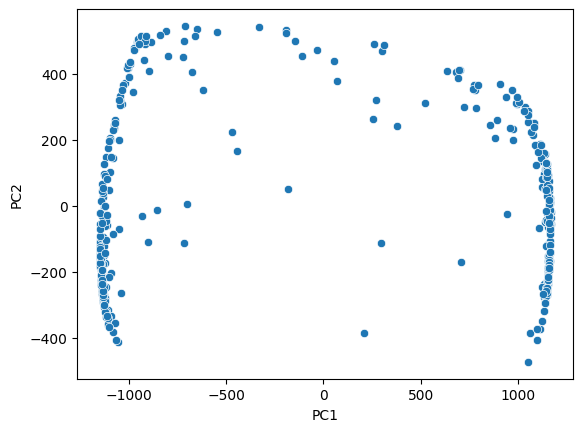

('Intersection of top 500 features (less than 0): ', 22)
('Intersection of top 1000 features (less than 0): ', 118)
('Intersection of top 2000 features (less than 0): ', 432)
('Intersection of top 4000 features (less than 0): ', 1643)
('Intersection of top 500 features (more than 0): ', 46)
('Intersection of top 1000 features (more than 0): ', 150)
('Intersection of top 2000 features (more than 0): ', 477)
('Intersection of top 4000 features (more than 0): ', 1641)


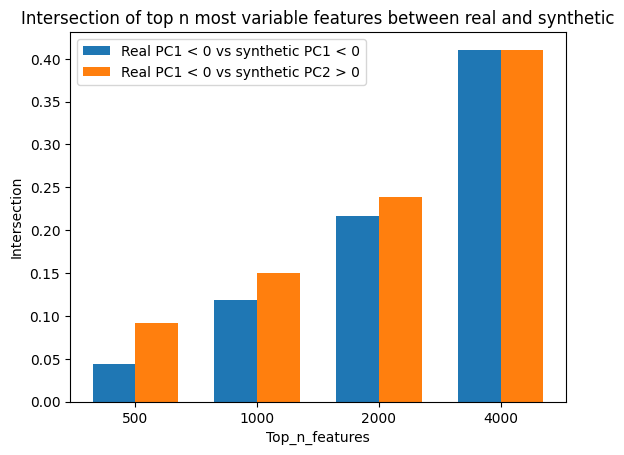

[336, 1004, 1638, 1999]
[251, 424, 699, 956]


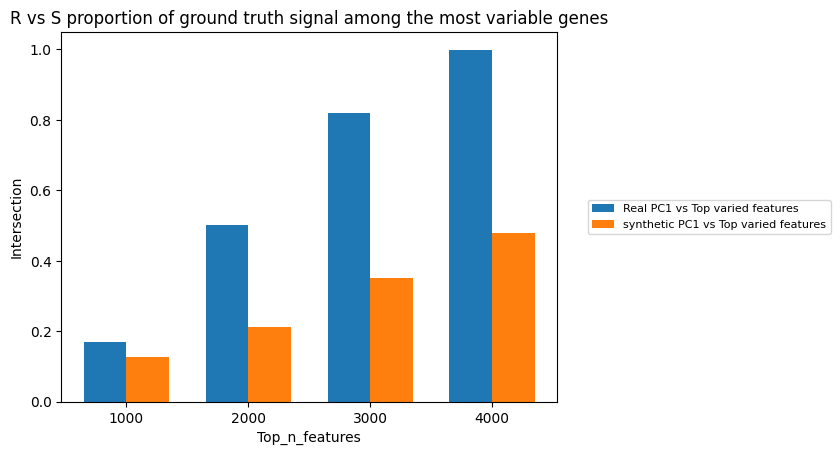

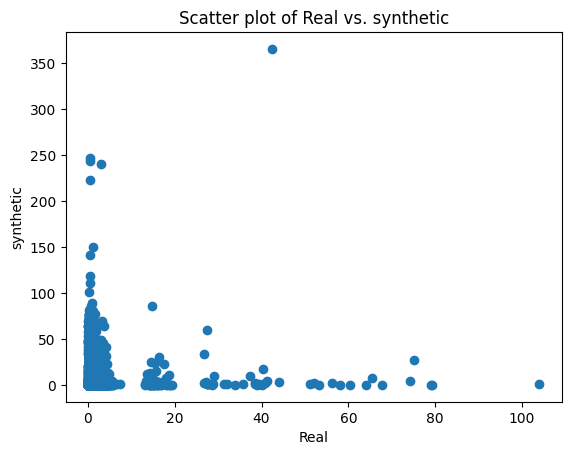

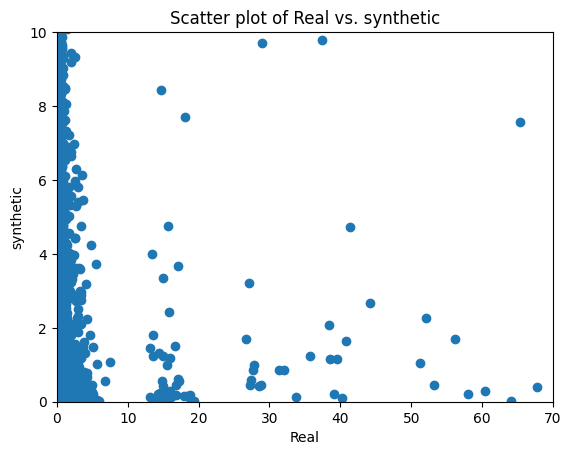

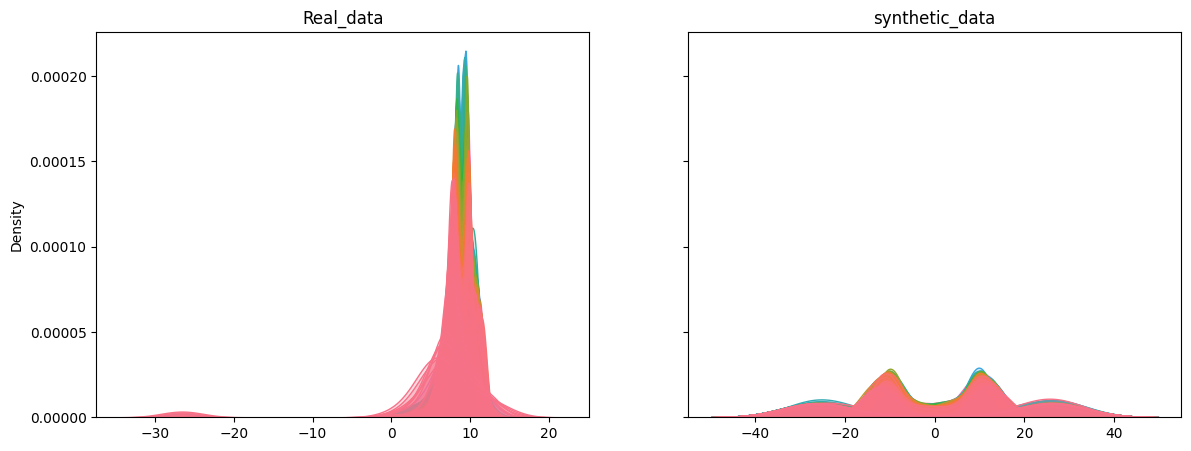

426
Recall is: 0.213
Precision is: 0.20780487804878048


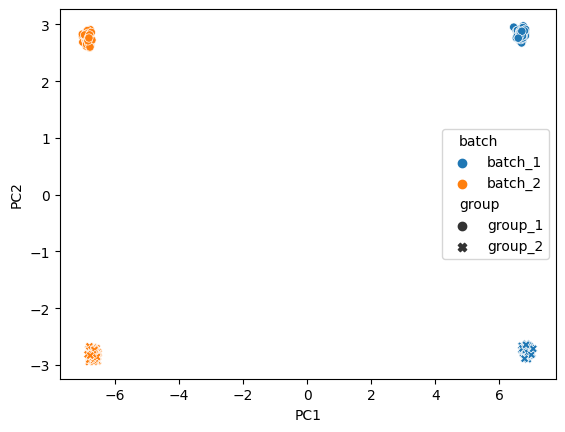

2/2 [==============================] - 0s 8ms/step
Epoch 1/1000 - Discriminator Loss: 6.095419250428677 - Generator Loss: 8.525805473327637
2/2 [==============================] - 0s 7ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.481410503387451
2/2 [==============================] - 0s 7ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 8.321059226989746
2/2 [==============================] - 0s 8ms/step
Epoch 4/1000 - Discriminator Loss: 0.48202964663505554 - Generator Loss: 7.953588962554932
2/2 [==============================] - 0s 4ms/step
Epoch 5/1000 - Discriminator Loss: 1.0846149921417236 - Generator Loss: 7.592050552368164
2/2 [==============================] - 0s 15ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.833181858062744
2/2 [==============================] - 0s 11ms/step
Epoch 7/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.471458911895752
2/2 [==============================] - 0s 7ms/step
Epoch 8/1000 - Discr

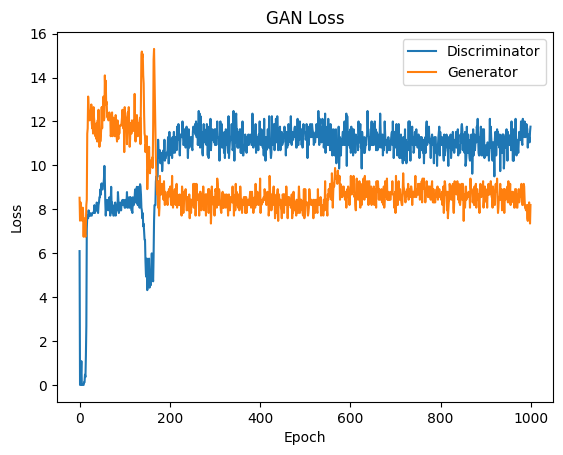

13/13 [==============================] - 0s 5ms/step


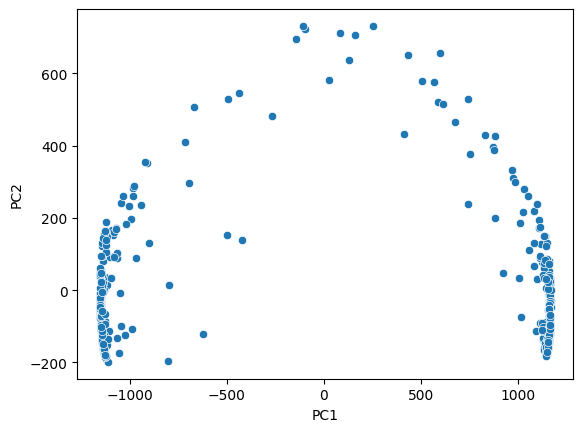

('Intersection of top 500 features (less than 0): ', 32)
('Intersection of top 1000 features (less than 0): ', 110)
('Intersection of top 2000 features (less than 0): ', 404)
('Intersection of top 4000 features (less than 0): ', 1594)
('Intersection of top 500 features (more than 0): ', 28)
('Intersection of top 1000 features (more than 0): ', 100)
('Intersection of top 2000 features (more than 0): ', 385)
('Intersection of top 4000 features (more than 0): ', 1595)


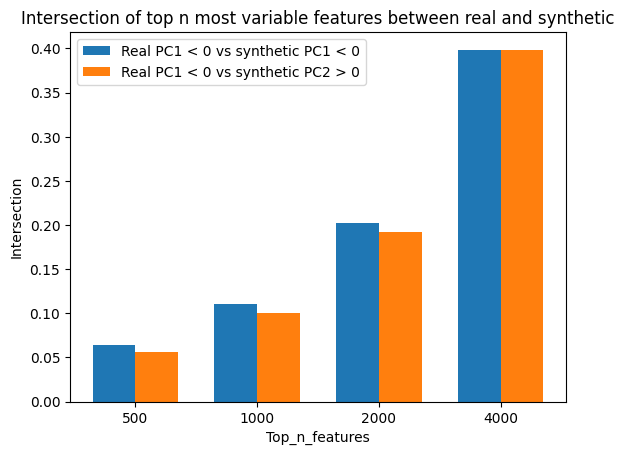

[350, 1011, 1671, 1999]
[255, 489, 781, 958]


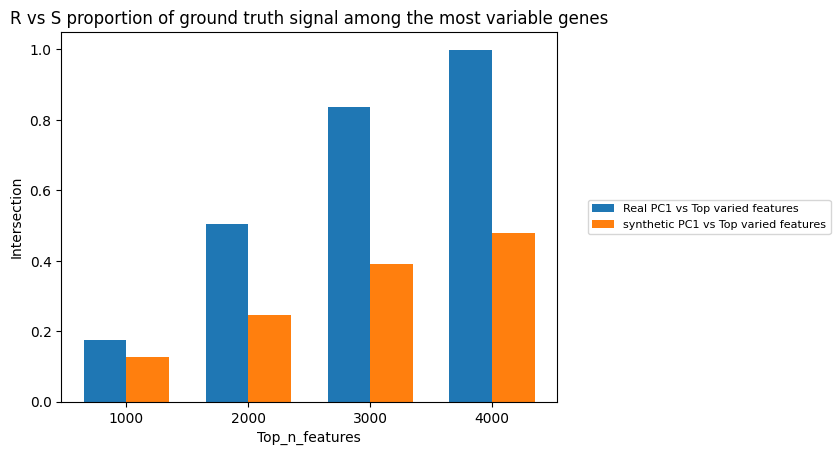

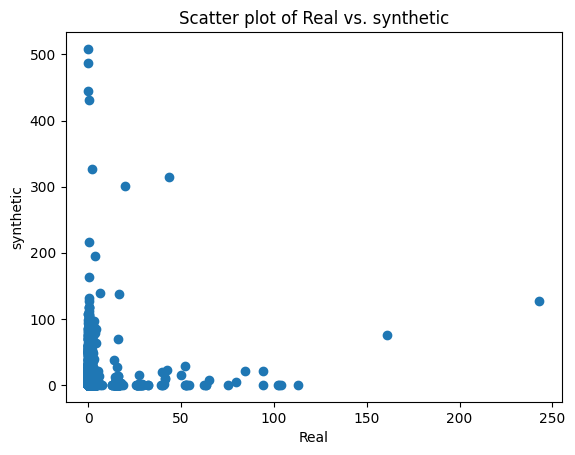

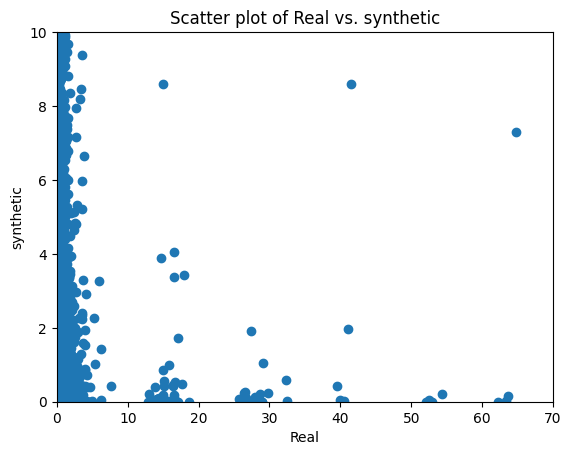

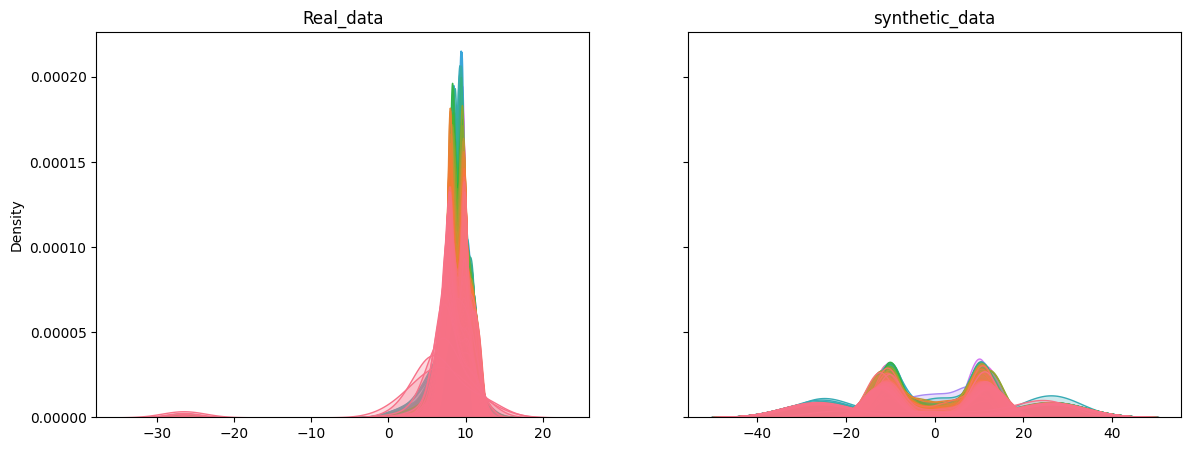

467
Recall is: 0.2335
Precision is: 0.2278048780487805


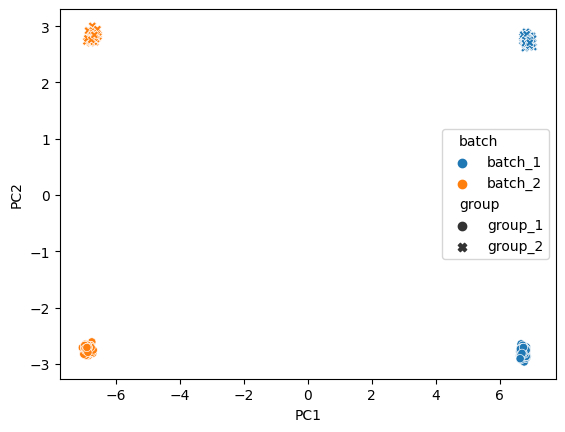

2/2 [==============================] - 0s 6ms/step
Epoch 1/1000 - Discriminator Loss: 3.9684022665023804 - Generator Loss: 8.41472339630127
2/2 [==============================] - 0s 12ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 8.07560920715332
2/2 [==============================] - 0s 5ms/step
Epoch 3/1000 - Discriminator Loss: 0.12050741165876389 - Generator Loss: 7.11017370223999
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 - Discriminator Loss: 0.24101482331752777 - Generator Loss: 7.5926055908203125
2/2 [==============================] - 0s 10ms/step
Epoch 5/1000 - Discriminator Loss: 0.8435518741607666 - Generator Loss: 7.351960182189941
2/2 [==============================] - 0s 5ms/step
Epoch 6/1000 - Discriminator Loss: 1.5674505233764648 - Generator Loss: 7.230444431304932
2/2 [==============================] - 0s 9ms/step
Epoch 7/1000 - Discriminator Loss: 0.2418210804462433 - Generator Loss: 7.731359481811523
2/2 [=====================

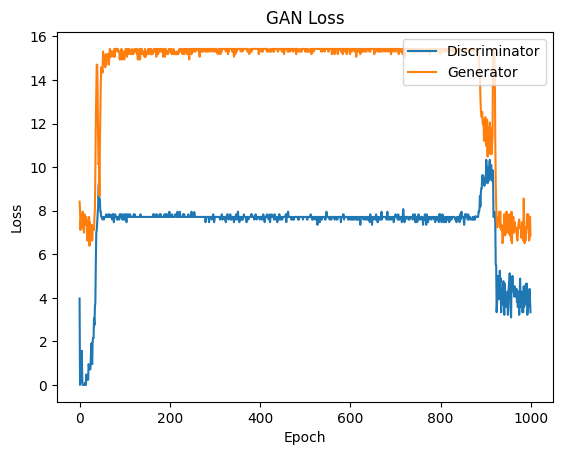

13/13 [==============================] - 0s 5ms/step


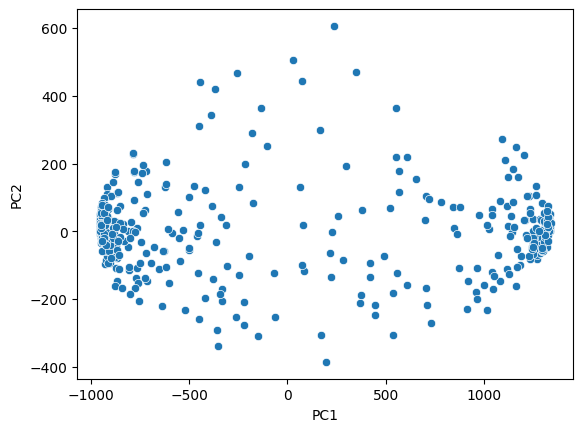

('Intersection of top 500 features (less than 0): ', 127)
('Intersection of top 1000 features (less than 0): ', 198)
('Intersection of top 2000 features (less than 0): ', 504)
('Intersection of top 4000 features (less than 0): ', 1698)
('Intersection of top 500 features (more than 0): ', 143)
('Intersection of top 1000 features (more than 0): ', 205)
('Intersection of top 2000 features (more than 0): ', 521)
('Intersection of top 4000 features (more than 0): ', 1714)


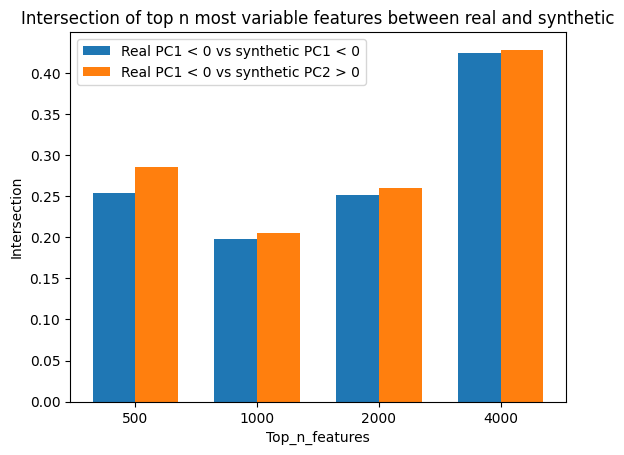

[327, 963, 1648, 2000]
[287, 491, 723, 976]


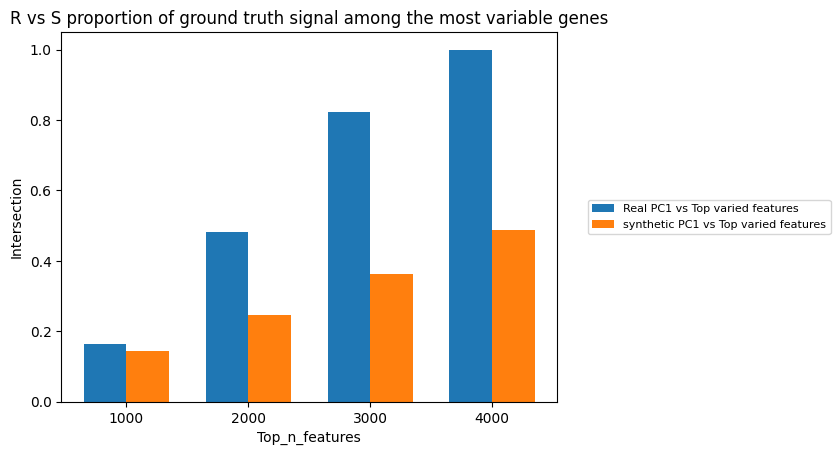

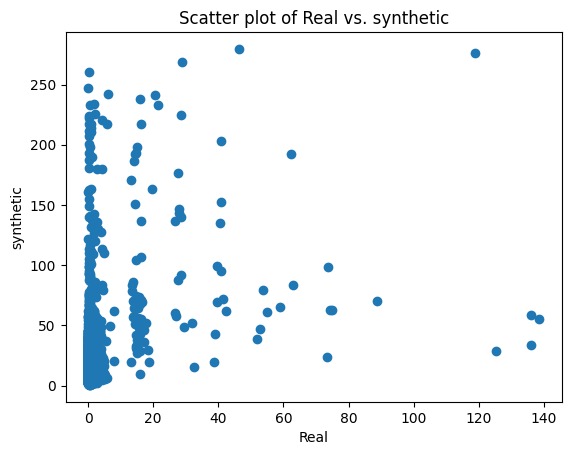

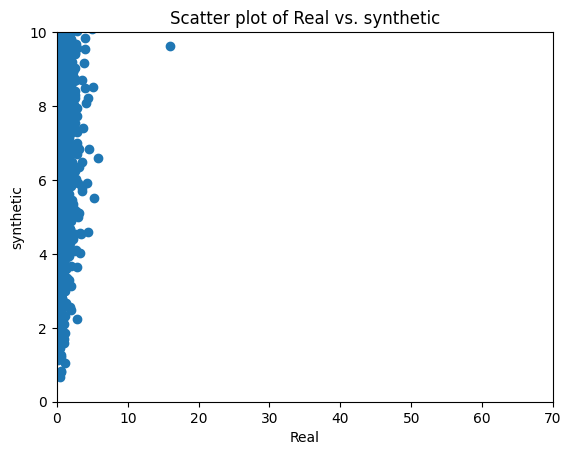

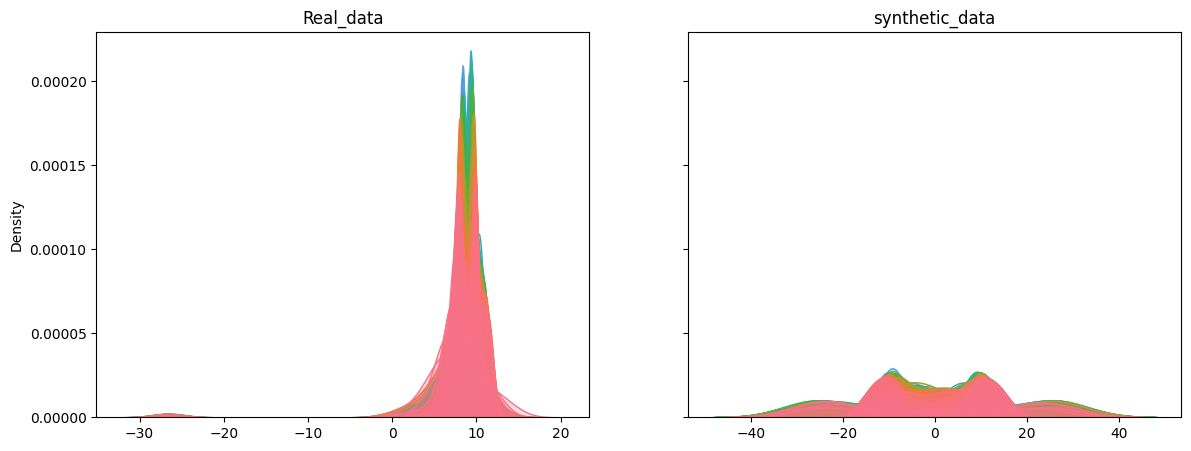

427
Recall is: 0.2135
Precision is: 0.20829268292682926


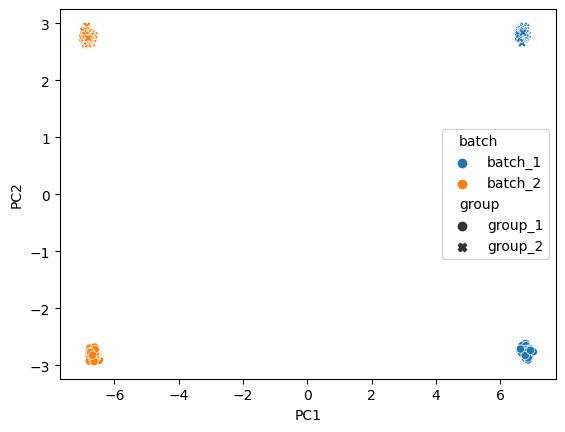

2/2 [==============================] - 0s 9ms/step
Epoch 1/1000 - Discriminator Loss: 3.6941622272133827 - Generator Loss: 7.005417823791504
2/2 [==============================] - 0s 7ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.38735294342041
2/2 [==============================] - 0s 8ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.471769332885742
2/2 [==============================] - 0s 14ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.351238250732422
2/2 [==============================] - 0s 10ms/step
Epoch 5/1000 - Discriminator Loss: 0.0 - Generator Loss: 6.989429473876953
2/2 [==============================] - 0s 17ms/step
Epoch 6/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.474876880645752
2/2 [==============================] - 0s 14ms/step
Epoch 7/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.1099371910095215
2/2 [==============================] - 0s 10ms/step
Epoch 8/1000 - Discriminator Loss: 0.0 - Genera

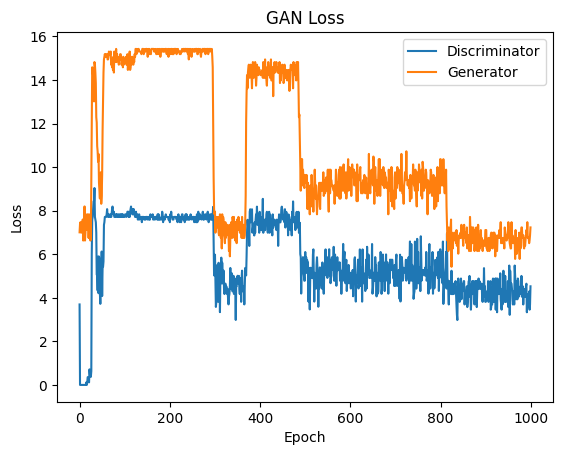

13/13 [==============================] - 0s 4ms/step


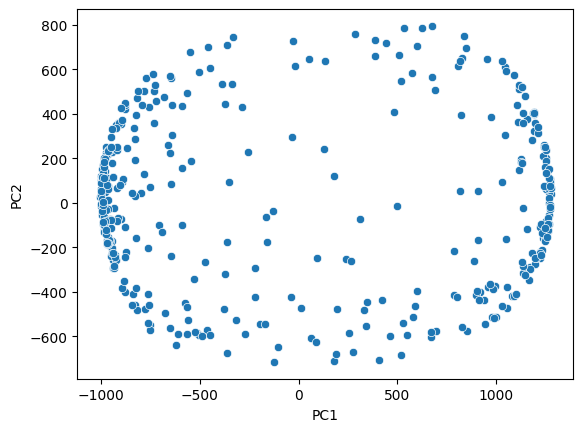

('Intersection of top 500 features (less than 0): ', 85)
('Intersection of top 1000 features (less than 0): ', 186)
('Intersection of top 2000 features (less than 0): ', 470)
('Intersection of top 4000 features (less than 0): ', 1675)
('Intersection of top 500 features (more than 0): ', 117)
('Intersection of top 1000 features (more than 0): ', 190)
('Intersection of top 2000 features (more than 0): ', 478)
('Intersection of top 4000 features (more than 0): ', 1700)


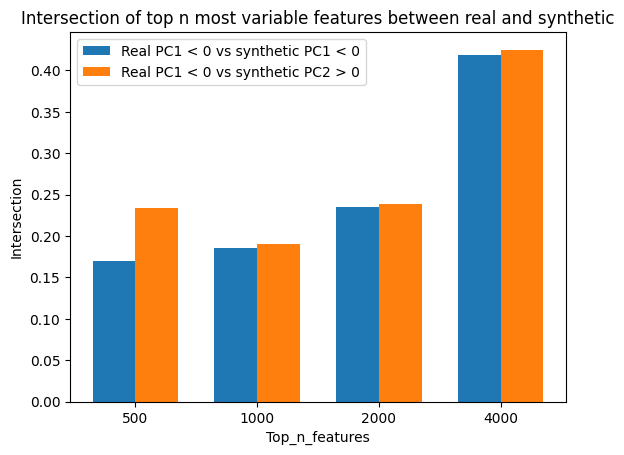

[322, 952, 1644, 2000]
[289, 463, 688, 970]


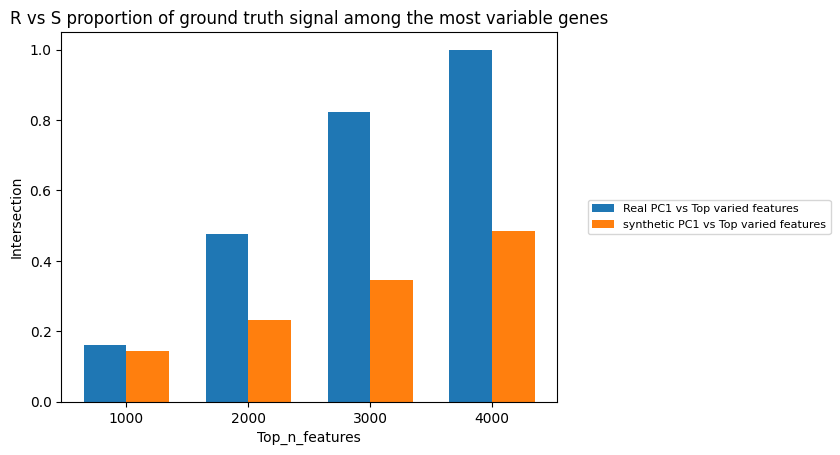

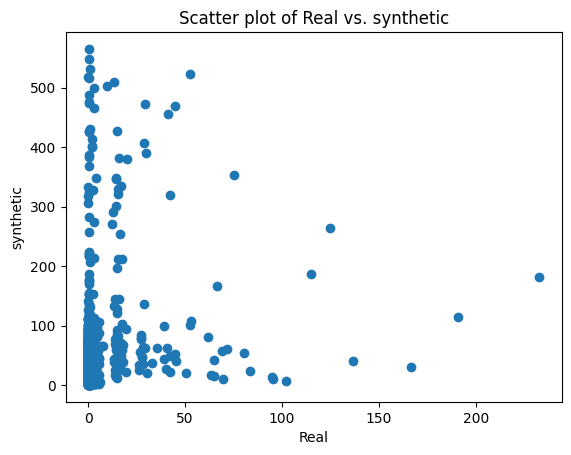

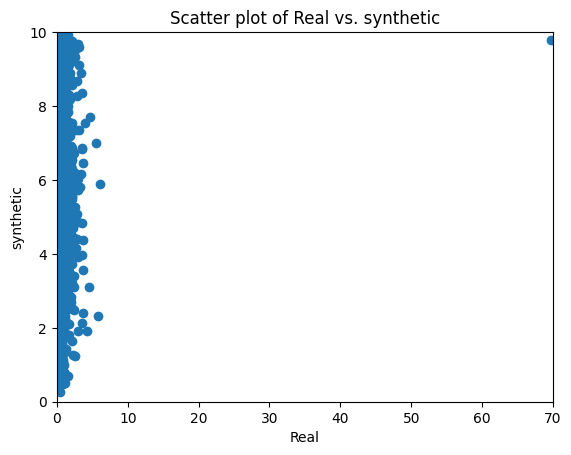

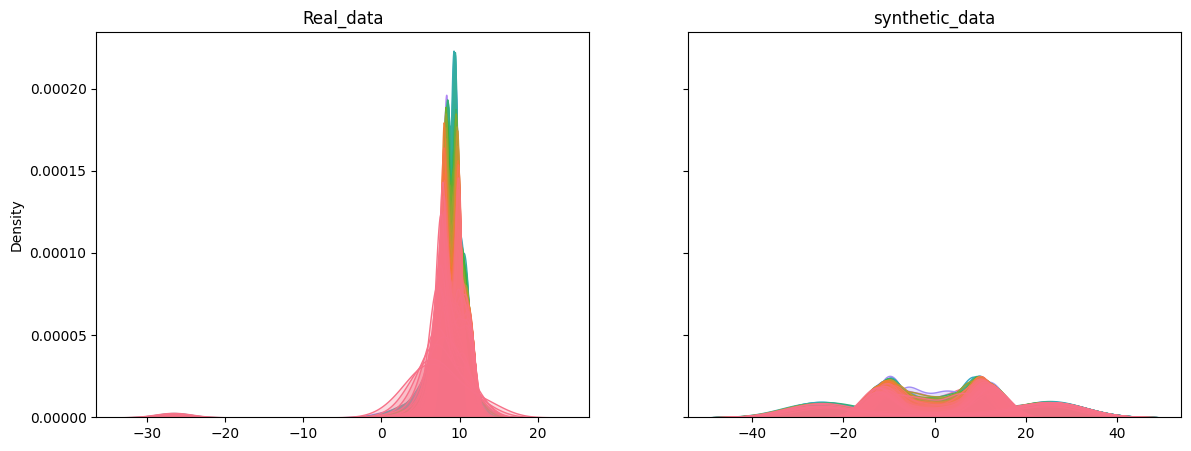

450
Recall is: 0.225
Precision is: 0.21951219512195122


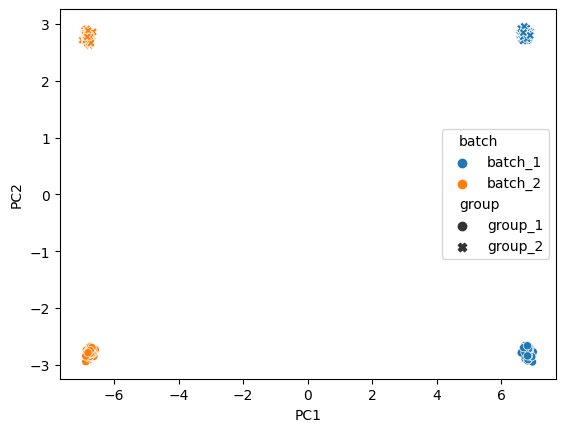

2/2 [==============================] - 0s 6ms/step
Epoch 1/1000 - Discriminator Loss: 3.016044020652771 - Generator Loss: 7.949472904205322
2/2 [==============================] - 0s 5ms/step
Epoch 2/1000 - Discriminator Loss: 0.0 - Generator Loss: 8.46918773651123
2/2 [==============================] - 0s 6ms/step
Epoch 3/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.765477180480957
2/2 [==============================] - 0s 5ms/step
Epoch 4/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.492386341094971
2/2 [==============================] - 0s 5ms/step
Epoch 5/1000 - Discriminator Loss: 0.0 - Generator Loss: 7.832981586456299
2/2 [==============================] - 0s 10ms/step
Epoch 6/1000 - Discriminator Loss: 0.24101482331752777 - Generator Loss: 7.111778736114502
2/2 [==============================] - 0s 5ms/step
Epoch 7/1000 - Discriminator Loss: 0.24101482331752777 - Generator Loss: 7.7124738693237305
2/2 [==============================] - 0s 9ms/step
Epoch 8/1000 - Discr

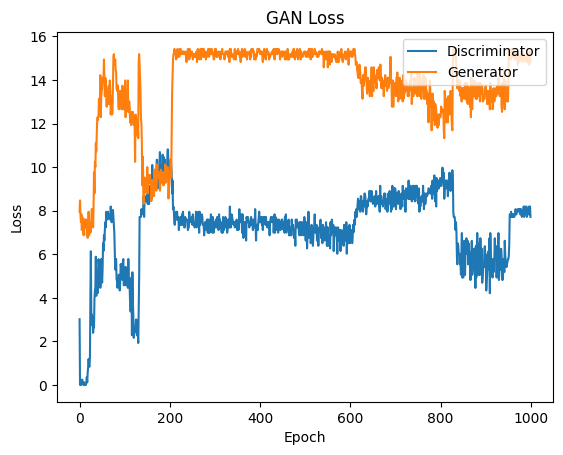

13/13 [==============================] - 0s 5ms/step


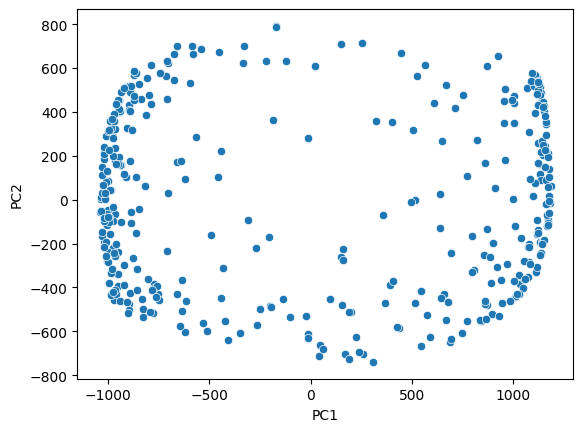

('Intersection of top 500 features (less than 0): ', 84)
('Intersection of top 1000 features (less than 0): ', 194)
('Intersection of top 2000 features (less than 0): ', 484)
('Intersection of top 4000 features (less than 0): ', 1707)
('Intersection of top 500 features (more than 0): ', 137)
('Intersection of top 1000 features (more than 0): ', 218)
('Intersection of top 2000 features (more than 0): ', 490)
('Intersection of top 4000 features (more than 0): ', 1700)


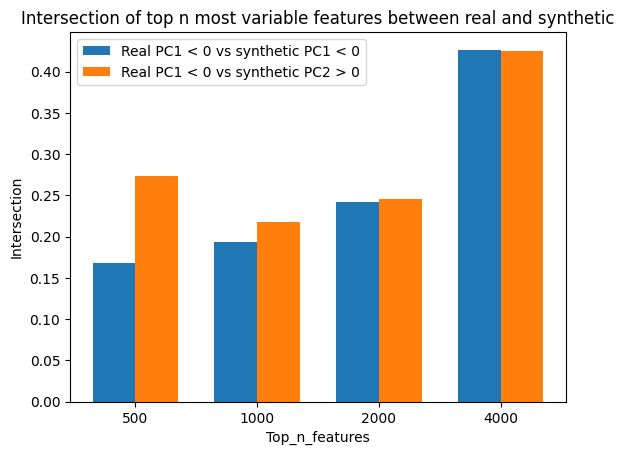

[339, 975, 1656, 2000]
[324, 491, 679, 921]


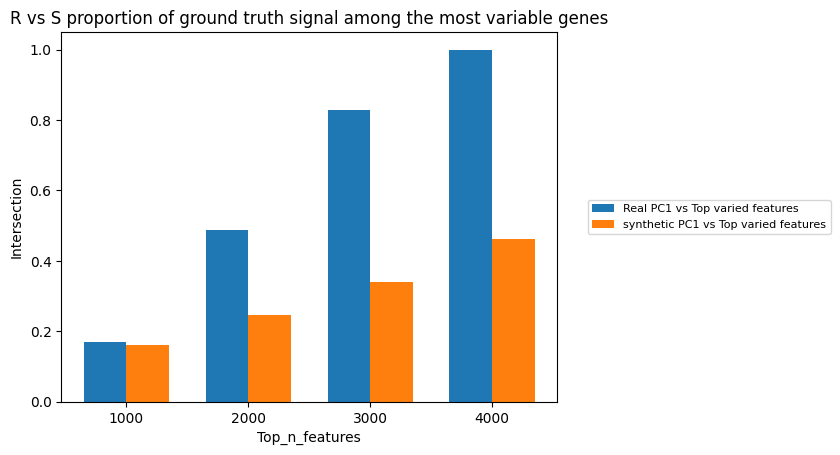

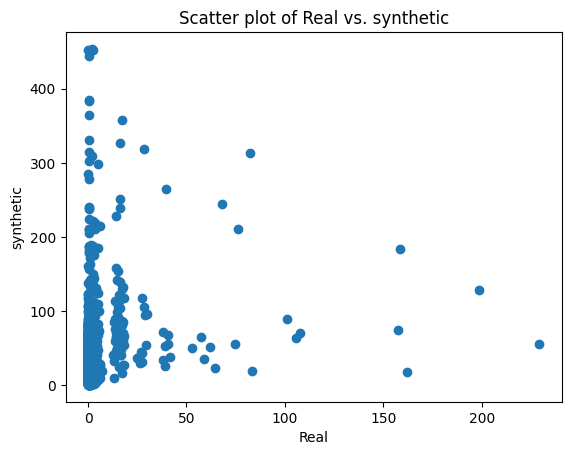

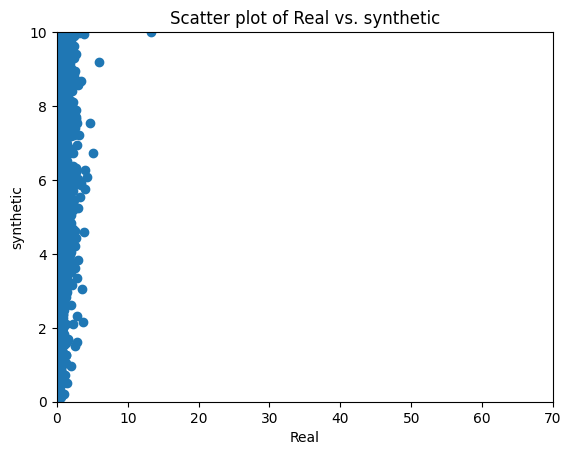

459
Recall is: 0.2295
Precision is: 0.22390243902439025


'Sucessfully trained'

In [ ]:
train_GAN()